# I. Importing libraries and dataset 

In [158]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from src import woe_discrete, plot_by_woe
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
import re
import pickle
import warnings
warnings.filterwarnings("ignore")

In [159]:
loan_data_inputs_train = pd.read_csv('X_train.csv', index_col = 0)
loan_data_targets_train = pd.read_csv('y_train.csv', index_col = 0)
loan_data_inputs_test = pd.read_csv('X_test.csv', index_col = 0)
loan_data_targets_test = pd.read_csv('y_test.csv', index_col = 0)
loan_data_backup = pd.read_csv('loan_data_2015.csv')
loan_data = loan_data_backup.copy()

In [160]:
feature_list = pickle.load(open('feature_list', 'rb'))
ref_categories = pickle.load(open('ref_categories', 'rb'))

In [161]:
pd.options.display.max_columns = None

### Explore Data

In [162]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,68444620,73334399,35000,35000,35000.0,60 months,11.99,778.38,C,C1,Foreign Service Officer,10+ years,MORTGAGE,128000.0,Source Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,200xx,DC,6.46,0.0,Feb-90,0.0,46.0,NaN,17.0,0.0,14277,27.4,46.0,w,35000.0,35000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,56.0,1,INDIVIDUAL,NaN,NaN,NaN,0.0,321.0,146867.0,1.0,11.0,0.0,0.0,28.0,35367.0,49.3,0.0,1.0,5020.0,40.1,52200.0,1.0,4.0,0.0
1,68547583,73437441,8650,8650,8650.0,36 months,5.32,260.50,A,A1,Associate Consultant,< 1 year,MORTGAGE,100000.0,Not Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,462xx,IN,7.28,0.0,Jul-01,0.0,NaN,NaN,15.0,0.0,7158,26.7,24.0,w,8650.0,8650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,165450.0,0.0,1.0,1.0,1.0,11.0,24041.0,88.8,0.0,3.0,3081.0,57.9,26800.0,1.0,0.0,5.0
2,67849662,72708407,4225,4225,4225.0,36 months,14.85,146.16,C,C5,mechanic,5 years,RENT,35000.0,Source Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,672xx,KS,15.22,2.0,Jul-11,0.0,18.0,NaN,6.0,0.0,1058,24.6,6.0,w,4225.0,4225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,4888.0,0.0,1.0,0.0,0.0,47.0,3830.0,21.9,0.0,0.0,367.0,22.4,4300.0,0.0,0.0,0.0
3,68506885,73396712,10000,10000,10000.0,60 months,11.99,222.40,C,C1,CARDIOVASCULAR TECH,10+ years,RENT,42500.0,Not Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,460xx,IN,31.04,0.0,Dec-98,1.0,NaN,NaN,10.0,0.0,5812,40.9,23.0,w,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,41166.0,1.0,3.0,0.0,2.0,13.0,35354.0,75.5,1.0,1.0,3118.0,67.4,14200.0,1.0,1.0,1.0
4,68341763,72928789,20000,20000,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-00,0.0,NaN,NaN,6.0,0.0,7869,56.2,18.0,w,20000.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Dec-15,0.0,NaN,1,JOINT,71000.0,13.85,Not Verified,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,72.8,0.0,2.0,2081.0,64.7,14000.0,2.0,5.0,1.0


In [163]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421094 entries, 0 to 421093
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           421094 non-null  int64  
 1   member_id                    421094 non-null  int64  
 2   loan_amnt                    421094 non-null  int64  
 3   funded_amnt                  421094 non-null  int64  
 4   funded_amnt_inv              421094 non-null  float64
 5   term                         421094 non-null  object 
 6   int_rate                     421094 non-null  float64
 7   installment                  421094 non-null  float64
 8   grade                        421094 non-null  object 
 9   sub_grade                    421094 non-null  object 
 10  emp_title                    397220 non-null  object 
 11  emp_length                   397277 non-null  object 
 12  home_ownership               421094 non-null  object 
 13 

# III. Data preprocessing 

## 1. Drop redundant variables 

Variables with only one unique value or those with too many unique values (such as IDs or URLs) are removed, as they carry little predictive power.

In [164]:
loan_data.drop(['id', 'member_id', 'url', 'policy_code', 'application_type'], axis=1, inplace=True)

Features with all missing (null) values are also excluded from the dataset.

In [165]:
null_cols = []

for i in loan_data.columns:
    if loan_data[i].notna().sum() == 0:
        null_cols.append(i)
    elif loan_data[i].nunique() == 1:
        null_cols.append(i)

loan_data.drop(null_cols, axis=1, inplace=True)

The remaining variables/features include:

In [166]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421094 entries, 0 to 421093
Data columns (total 69 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    421094 non-null  int64  
 1   funded_amnt                  421094 non-null  int64  
 2   funded_amnt_inv              421094 non-null  float64
 3   term                         421094 non-null  object 
 4   int_rate                     421094 non-null  float64
 5   installment                  421094 non-null  float64
 6   grade                        421094 non-null  object 
 7   sub_grade                    421094 non-null  object 
 8   emp_title                    397220 non-null  object 
 9   emp_length                   397277 non-null  object 
 10  home_ownership               421094 non-null  object 
 11  annual_inc                   421094 non-null  float64
 12  verification_status          421094 non-null  object 
 13 

## 2. Datetime Processing 

### 2.1. emp_length 

In [167]:
loan_data['emp_length'].unique()

array(['10+ years', '< 1 year', '5 years', '3 years', '4 years', nan,
       '2 years', '8 years', '9 years', '1 year', '6 years', '7 years'],
      dtype=object)

In [168]:
loan_data['emp_length'] = loan_data['emp_length'].fillna('0')
loan_data['emp_length'] = loan_data['emp_length'].str.replace(r'\+ years', '', regex=True)
loan_data['emp_length'] = loan_data['emp_length'].str.replace(r' years?', '', regex=True)
loan_data['emp_length'] = loan_data['emp_length'].str.replace(r'< 1', '0', regex=True)
loan_data['emp_length'] = pd.to_numeric(loan_data['emp_length'], errors='coerce').fillna(0).astype(int)

In [169]:
loan_data['emp_length'].unique()

array([10,  0,  5,  3,  4,  2,  8,  9,  1,  6,  7])

### 2.2. earliest cr line 

In [170]:
loan_data['earliest_cr_line'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')

In [171]:
cutoff_date = pd.Timestamp('2017-12-01')

loan_data.loc[(loan_data['earliest_cr_line'] > cutoff_date) & (loan_data['earliest_cr_line'].dt.year > 2020), 'earliest_cr_line'] = \
    loan_data['earliest_cr_line'] - pd.DateOffset(years=100)

In [172]:
loan_data['earliest_cr_line']

0        1990-02-01
1        2001-07-01
2        2011-07-01
3        1998-12-01
4        2000-08-01
            ...    
421089   2004-09-01
421090   1974-03-01
421091   2003-09-01
421092   2003-10-01
421093   2001-12-01
Name: earliest_cr_line, Length: 421094, dtype: datetime64[ns]

In [173]:
pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line']

0        10165 days
1         5997 days
2         2345 days
3         6940 days
4         6331 days
            ...    
421089    4839 days
421090   15981 days
421091    5205 days
421092    5175 days
421093    5844 days
Name: earliest_cr_line, Length: 421094, dtype: timedelta64[ns]

In [174]:
loan_data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line']) / np.timedelta64(1, 'D') / 30.44))

In [175]:
loan_data['mths_since_earliest_cr_line'].describe()

count    421094.000000
mean        230.586458
std          91.329014
min          61.000000
25%         168.000000
50%         212.000000
75%         278.000000
max         887.000000
Name: mths_since_earliest_cr_line, dtype: float64

### 2.3. term

In [176]:
loan_data['term'].unique()

array([' 60 months', ' 36 months'], dtype=object)

In [177]:
loan_data['term_int'] = loan_data['term'].str.replace(r'\D', '', regex=True)

In [178]:
loan_data['term_int'] = pd.to_numeric(loan_data['term_int'])

In [179]:
loan_data['term_int']

0         60
1         36
2         36
3         60
4         60
          ..
421089    36
421090    36
421091    60
421092    60
421093    36
Name: term_int, Length: 421094, dtype: int64

In [180]:
loan_data['term_int'].unique()

array([60, 36], dtype=int64)

### 2.4. issue_d

In [181]:
loan_data['issue_d'].unique()

array(['Dec-15', 'Nov-15', 'Oct-15', 'Sep-15', 'Aug-15', 'Jul-15',
       'Jun-15', 'May-15', 'Apr-15', 'Mar-15', 'Feb-15', 'Jan-15'],
      dtype=object)

In [182]:
# Y là cả năm, y chỉ lấy 2 số cuối 
loan_data['issue_d'] = pd.to_datetime(loan_data['issue_d'], format='%b-%y')

In [183]:
loan_data['mths_since_issue_d'] = round((pd.to_datetime('2017-12-01', format='%Y-%m-%d') - loan_data['issue_d']) / np.timedelta64(1, 'D') / 30.44)

In [184]:
loan_data['mths_since_issue_d'].describe()

count    421094.000000
mean         29.044629
std           3.458162
min          24.000000
25%          26.000000
50%          29.000000
75%          32.000000
max          35.000000
Name: mths_since_issue_d, dtype: float64

## 3. Encoding

In [185]:
loan_data_dummies = [pd.get_dummies(loan_data['grade'], prefix='grade', prefix_sep=':').astype(int),
              pd.get_dummies(loan_data['sub_grade'], prefix='sub_grade', prefix_sep=':').astype(int),
              pd.get_dummies(loan_data['home_ownership'], prefix='home_ownership', prefix_sep=':').astype(int),
              pd.get_dummies(loan_data['verification_status'], prefix='verification_status', prefix_sep=':').astype(int),
              pd.get_dummies(loan_data['loan_status'], prefix='loan_status', prefix_sep=':').astype(int),
              pd.get_dummies(loan_data['purpose'], prefix='purpose', prefix_sep=':').astype(int),
              pd.get_dummies(loan_data['addr_state'], prefix='addr_state', prefix_sep=':').astype(int),
              pd.get_dummies(loan_data['initial_list_status'], prefix='initial_list_status', prefix_sep=':').astype(int)]

In [186]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [187]:
type(loan_data_dummies)

pandas.core.frame.DataFrame

In [188]:
loan_data = pd.concat([loan_data, loan_data_dummies], axis = 1)

In [189]:
loan_data.columns.values

array(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc

## 4. Missing value

In [190]:
loan_data.isnull()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,mths_since_earliest_cr_line,term_int,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Issued,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:ND,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [191]:
pd.options.display.max_rows = None
loan_data.isnull().sum()

loan_amnt                                   0
funded_amnt                                 0
funded_amnt_inv                             0
term                                        0
int_rate                                    0
installment                                 0
grade                                       0
sub_grade                                   0
emp_title                               23874
emp_length                                  0
home_ownership                              0
annual_inc                                  0
verification_status                         0
issue_d                                     0
loan_status                                 0
pymnt_plan                                  0
desc                                   421049
purpose                                     0
title                                     132
zip_code                                    0
addr_state                                  0
dti                               

In [192]:
pd.options.display.max_rows = 100

In [193]:
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace = True)

In [194]:
loan_data['total_rev_hi_lim'].isnull().sum()

0

In [195]:
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)

In [196]:
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length'].fillna(0, inplace=True)

## 5. Dependent variable

A common definition of default is that the borrower has defaulted if they are more than 90 days past due on a loan.

In [197]:
loan_data['loan_status'].unique()

array(['Issued', 'Current', 'Fully Paid', 'In Grace Period',
       'Late (16-30 days)', 'Late (31-120 days)', 'Charged Off',
       'Default'], dtype=object)

In [198]:
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'Late (31-120 days)']), 0, 1)

To assess population stability, we don't really need a train and test dataset.

In [199]:
# X_train, X_test, y_train, y_test = train_test_split(loan_data.drop('good_bad', axis = 1), loan_data['good_bad'], test_size = 0.2, random_state = 42)
df_inputs_prepr = loan_data.drop('good_bad', axis = 1)
df_targets_prepr = loan_data['good_bad']
# df_inputs_prepr = X_test
# df_targets_prepr = y_test

## 6. Feature transformation

### 6.1. Discrete variables

#### 6.1.1. grade

In [200]:
loan_data_temp = woe_discrete(df_inputs_prepr, 'grade', df_targets_prepr)
loan_data_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2167,0.904015,0.005146,1959.0,208.0,0.004741,0.026493,-1.720744,NaN,NaN,0.633941
1,F,9817,0.930529,0.023313,9135.0,682.0,0.022106,0.086868,-1.368556,0.017365,0.352187,0.633941
2,E,34948,0.956936,0.082993,33443.0,1505.0,0.080928,0.191695,-0.862345,0.058823,0.506211,0.633941
3,D,62654,0.967488,0.148789,60617.0,2037.0,0.146686,0.259457,-0.570298,0.065758,0.292048,0.633941
4,C,120567,0.982541,0.286318,118462.0,2105.0,0.286664,0.268119,0.066882,0.139978,0.637180,0.633941
5,B,117606,0.991097,0.279287,116559.0,1047.0,0.282059,0.133359,0.749074,0.004605,0.682192,0.633941
6,A,73335,0.996359,0.174154,73068.0,267.0,0.176816,0.034008,1.648502,0.105243,0.899428,0.633941


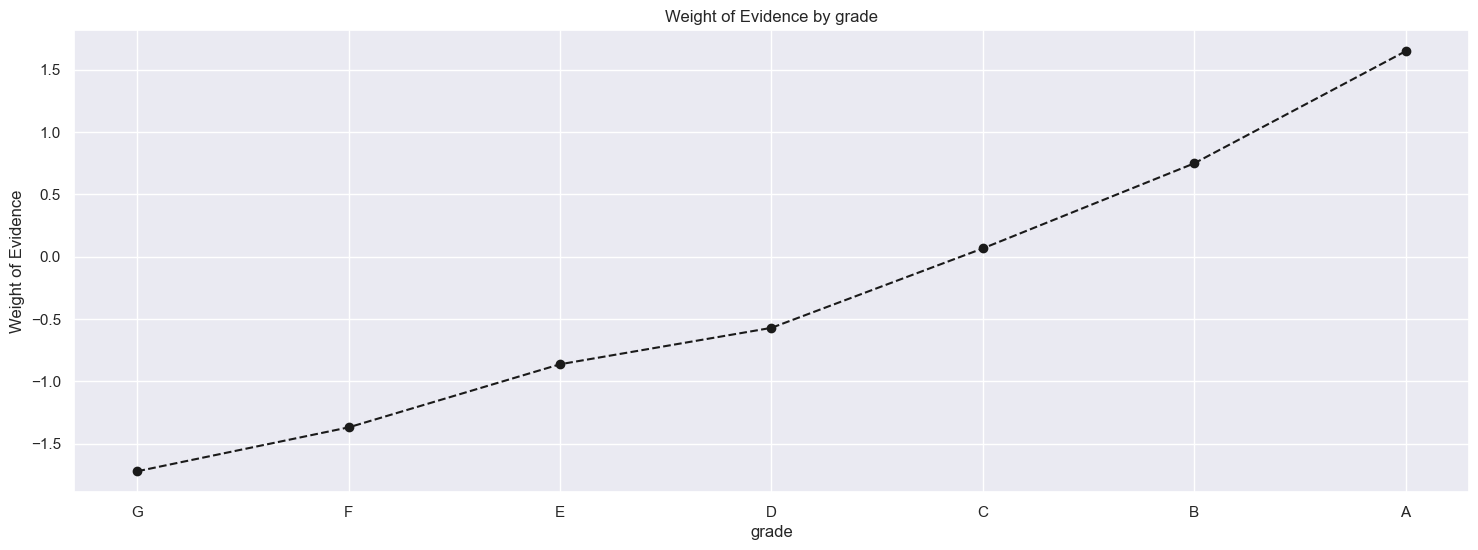

In [201]:
plot_by_woe(loan_data_temp)

#### 6.1.2. home_ownership

In [202]:
loan_data_temp = woe_discrete(df_inputs_prepr, 'home_ownership', df_targets_prepr)
loan_data_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,RENT,167644,0.976933,0.398115,163777.0,3867.0,0.396321,0.492549,-0.217368,NaN,NaN,inf
1,OWN,45766,0.980750,0.108684,44885.0,881.0,0.108616,0.112215,-0.032594,0.287705,0.184775,inf
2,MORTGAGE,207682,0.985059,0.493196,204579.0,3103.0,0.495057,0.395236,0.225190,0.386441,0.257784,inf
3,ANY,2,1.000000,0.000005,2.0,0.0,0.000005,0.000000,inf,0.495053,inf,inf


Some variables from the original dataset, such as 'home_ownership:NONE' and 'home_ownership:OTHER', are not present here.

In [203]:
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:ANY']])

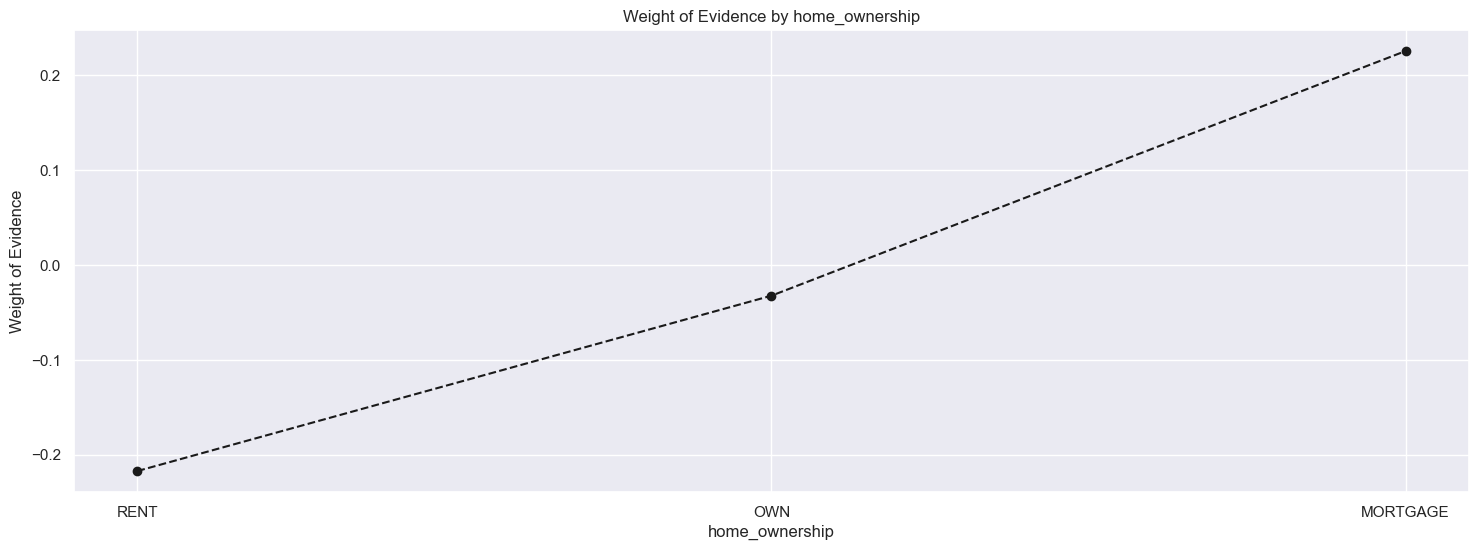

In [204]:
plot_by_woe(loan_data_temp)

#### 6.1.3. addr_state

In [205]:
loan_data_temp = woe_discrete(df_inputs_prepr, 'addr_state', df_targets_prepr)
loan_data_temp

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,NV,5924,0.969953,0.014068,5746.0,178.0,0.013905,0.022672,-0.488919,NaN,NaN,inf
1,SD,835,0.970060,0.001983,810.0,25.0,0.001960,0.003184,-0.485236,0.011945,0.003683,inf
2,HI,2083,0.973596,0.004947,2028.0,55.0,0.004908,0.007005,-0.355923,0.002947,0.129314,inf
3,OK,3968,0.976310,0.009423,3874.0,94.0,0.009375,0.011973,-0.244647,0.004467,0.111276,inf
4,AK,954,0.977987,0.002266,933.0,21.0,0.002258,0.002675,-0.169512,0.007117,0.075135,inf
5,NY,33844,0.978253,0.080372,33108.0,736.0,0.080118,0.093746,-0.157095,0.077860,0.012417,inf
6,AL,5347,0.978306,0.012698,5231.0,116.0,0.012658,0.014775,-0.154627,0.067459,0.002467,inf
7,UT,2836,0.978491,0.006735,2775.0,61.0,0.006715,0.007770,-0.145863,0.005943,0.008765,inf
8,WY,900,0.978889,0.002137,881.0,19.0,0.002132,0.002420,-0.126776,0.004583,0.019086,inf
9,FL,29298,0.979111,0.069576,28686.0,612.0,0.069417,0.077952,-0.115963,0.067285,0.010814,inf


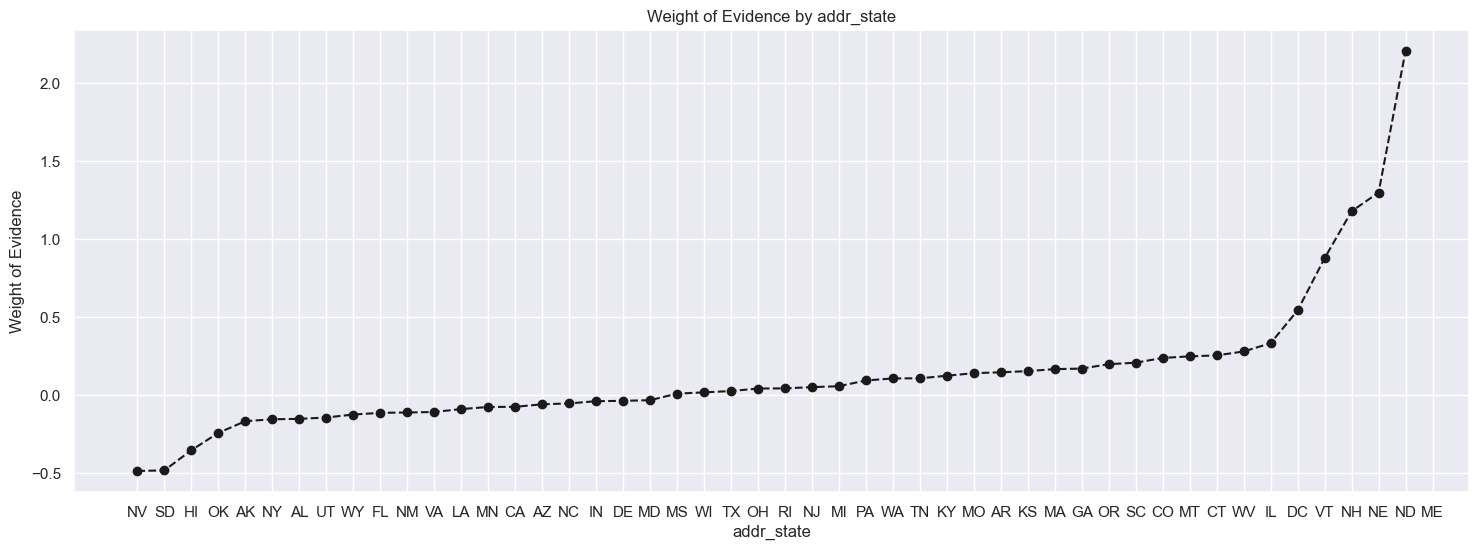

In [206]:
plot_by_woe(loan_data_temp)

In [207]:
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0    

2 missing states are Idaho and Iowa 

In [208]:
if ['addr_state:ID'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ID'] = 0    

In [209]:
if ['addr_state:IA'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:IA'] = 0    

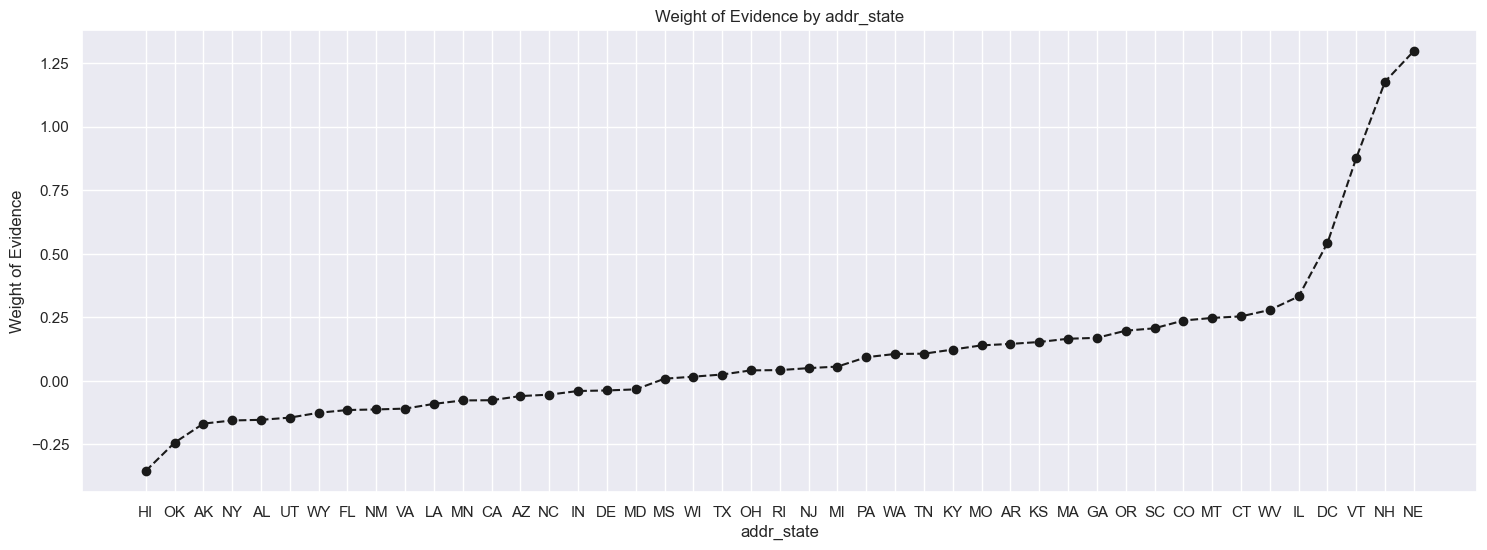

In [210]:
plot_by_woe(loan_data_temp.iloc[2: -2, :])

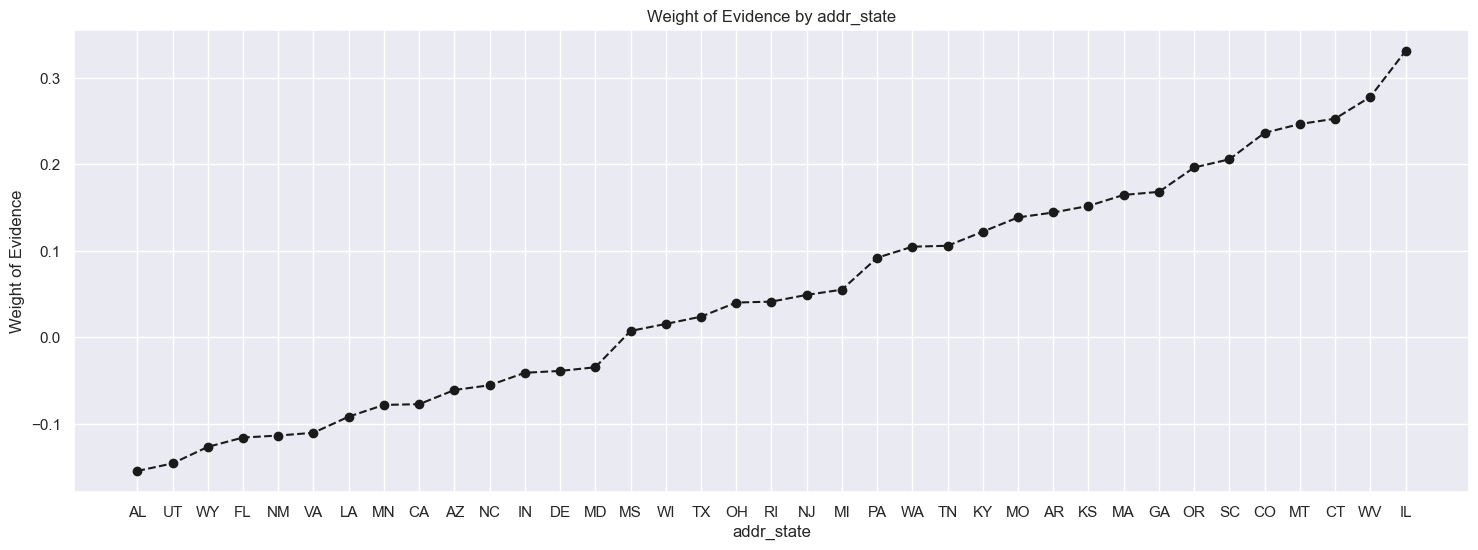

In [211]:
plot_by_woe(loan_data_temp.iloc[6: -6, :])

In [212]:
df_inputs_prepr['addr_state:ND_NE_IA'] = sum([df_inputs_prepr['addr_state:ND'], df_inputs_prepr['addr_state:NE'],
                                                         df_inputs_prepr['addr_state:IA']])

df_inputs_prepr['addr_state:NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state:NV'],df_inputs_prepr['addr_state:FL'], 
                                                        df_inputs_prepr['addr_state:HI'],
                                                         df_inputs_prepr['addr_state:AL']])

df_inputs_prepr['addr_state:NM_VA'] = sum([df_inputs_prepr['addr_state:NM'], df_inputs_prepr['addr_state:VA']])

df_inputs_prepr['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs_prepr['addr_state:OK'], df_inputs_prepr['addr_state:TN'],
                                              df_inputs_prepr['addr_state:MO'], df_inputs_prepr['addr_state:LA'],
                                              df_inputs_prepr['addr_state:MD'], df_inputs_prepr['addr_state:NC']])

df_inputs_prepr['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:KY'],
                                              df_inputs_prepr['addr_state:AZ'], df_inputs_prepr['addr_state:NJ']])

df_inputs_prepr['addr_state:AR_MI_PA_OH_MN'] = sum([df_inputs_prepr['addr_state:AR'], df_inputs_prepr['addr_state:MI'],
                                              df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:OH'],
                                              df_inputs_prepr['addr_state:MN']])

df_inputs_prepr['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs_prepr['addr_state:RI'], df_inputs_prepr['addr_state:MA'],
                                              df_inputs_prepr['addr_state:DE'], df_inputs_prepr['addr_state:SD'],
                                              df_inputs_prepr['addr_state:IN']])

df_inputs_prepr['addr_state:GA_WA_OR'] = sum([df_inputs_prepr['addr_state:GA'], df_inputs_prepr['addr_state:WA'],
                                              df_inputs_prepr['addr_state:OR']])

df_inputs_prepr['addr_state:WI_MT'] = sum([df_inputs_prepr['addr_state:WI'], df_inputs_prepr['addr_state:MT']])
df_inputs_prepr['addr_state:TX'] = sum([df_inputs_prepr['addr_state:TX']])
df_inputs_prepr['addr_state:IL_CT'] = sum([df_inputs_prepr['addr_state:IL'], df_inputs_prepr['addr_state:CT']])

df_inputs_prepr['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:SC'],
                                              df_inputs_prepr['addr_state:CO'], df_inputs_prepr['addr_state:VT'],
                                              df_inputs_prepr['addr_state:AK'], df_inputs_prepr['addr_state:MS']])

df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs_prepr['addr_state:WV'], df_inputs_prepr['addr_state:NH'],
                                              df_inputs_prepr['addr_state:WY'], df_inputs_prepr['addr_state:DC'],
                                              df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:ID']])

#### 6.1.4. verification_status

In [213]:
loan_data_temp = woe_discrete(df_inputs_prepr, 'verification_status', df_targets_prepr)

In [214]:
loan_data_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,123016,0.976532,0.292134,120129.0,2887.0,0.290698,0.367724,-0.235047,NaN,NaN,0.046808
1,Source Verified,179565,0.981110,0.426425,176173.0,3392.0,0.426318,0.432047,-0.013348,0.135620,0.221698,0.046808
2,Not Verified,118513,0.986736,0.281441,116941.0,1572.0,0.282984,0.200229,0.345926,0.143335,0.359274,0.046808


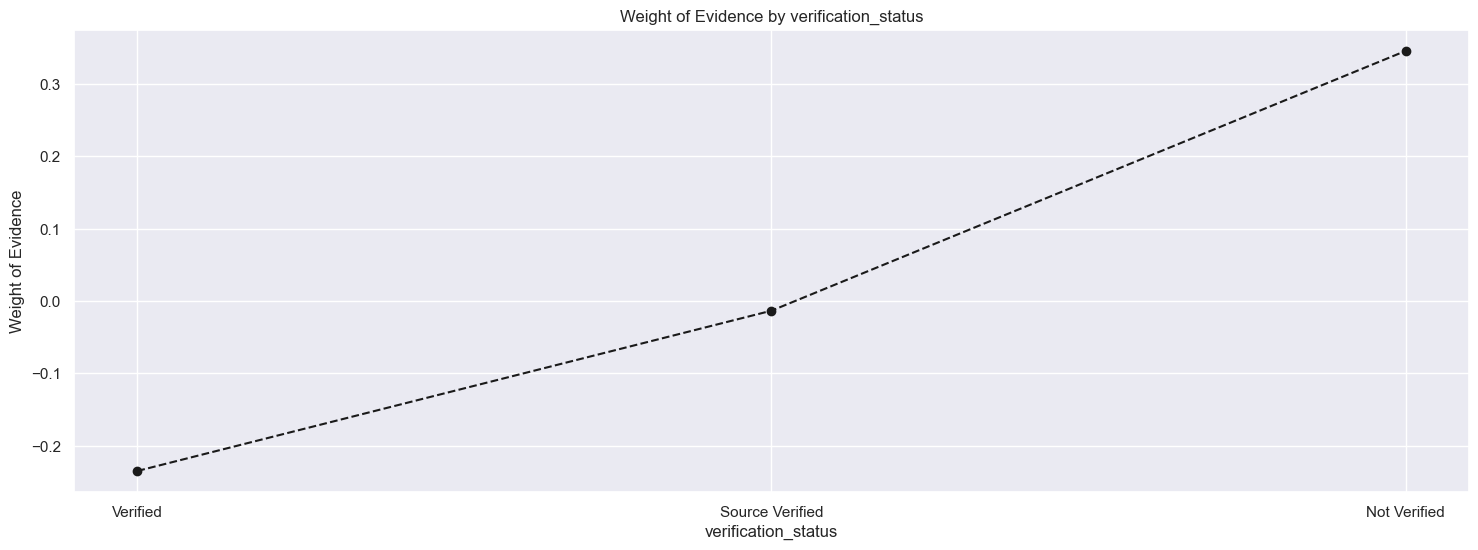

In [215]:
plot_by_woe(loan_data_temp)

#### 6.1.5. purpose

In [216]:
loan_data_temp = woe_discrete(df_inputs_prepr, 'purpose', df_targets_prepr)

In [217]:
loan_data_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,wedding,4,0.750000,0.000009,3.0,1.0,0.000007,0.000127,-2.864783,NaN,NaN,inf
1,renewable_energy,224,0.955357,0.000532,214.0,10.0,0.000518,0.001274,-0.900004,0.000511,1.964779,inf
2,small_business,3364,0.958680,0.007989,3225.0,139.0,0.007804,0.017705,-0.819181,0.007286,0.080823,inf
3,moving,2420,0.965289,0.005747,2336.0,84.0,0.005653,0.010699,-0.638016,0.002151,0.181164,inf
4,house,1438,0.967316,0.003415,1391.0,47.0,0.003366,0.005986,-0.575764,0.002287,0.062252,inf
5,medical,3938,0.970797,0.009352,3823.0,115.0,0.009251,0.014648,-0.459536,0.005885,0.116228,inf
6,major_purchase,7449,0.975970,0.017690,7270.0,179.0,0.017593,0.022800,-0.259269,0.008341,0.200267,inf
7,other,19204,0.976672,0.045605,18756.0,448.0,0.045387,0.057063,-0.228919,0.027795,0.030350,inf
8,vacation,2249,0.977768,0.005341,2199.0,50.0,0.005321,0.006369,-0.179660,0.040066,0.049259,inf
9,debt_consolidation,250020,0.979878,0.593739,244989.0,5031.0,0.592845,0.640810,-0.077800,0.587524,0.101860,inf


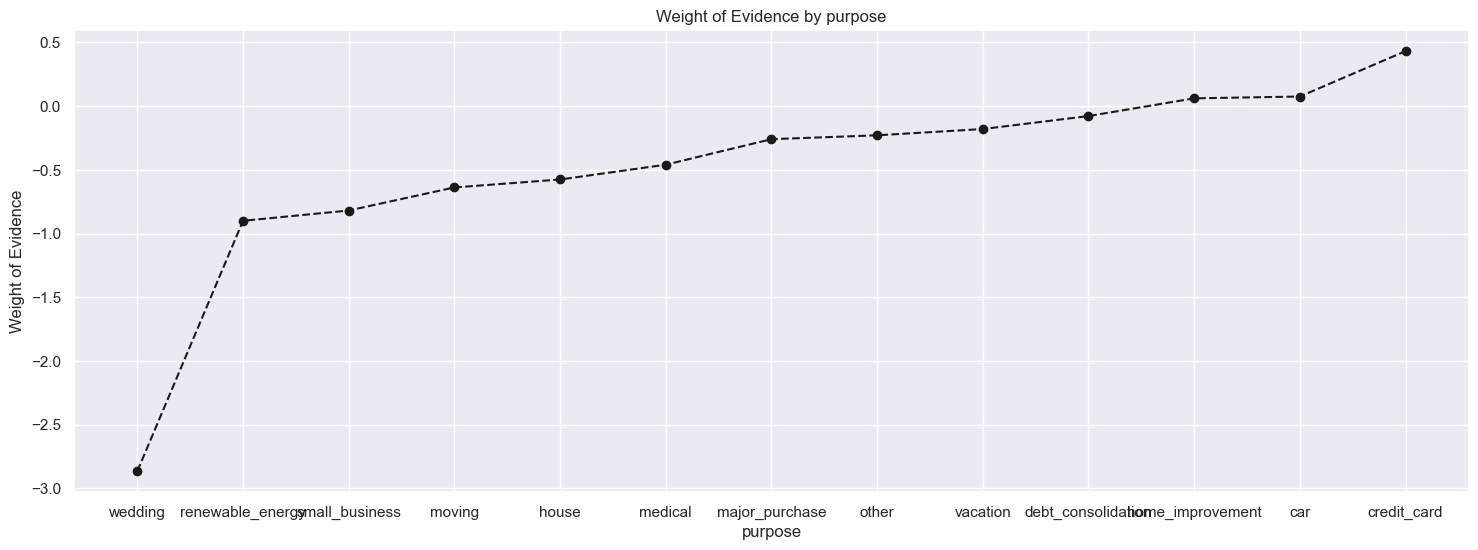

In [218]:
plot_by_woe(loan_data_temp)

In [219]:
df_inputs_prepr['purpose:educ__sm_b_mov'] = sum([df_inputs_prepr['purpose:educational'], df_inputs_prepr['purpose:small_business'], df_inputs_prepr['purpose:moving']])
df_inputs_prepr['purpose:oth__h__med__r_en'] = sum([df_inputs_prepr['purpose:other'], df_inputs_prepr['purpose:house'], df_inputs_prepr['purpose:medical'], df_inputs_prepr['purpose:renewable_energy']])
df_inputs_prepr['purpose:va__wed__debt_cons'] = sum([df_inputs_prepr['purpose:vacation'], df_inputs_prepr['purpose:wedding'], df_inputs_prepr['purpose:debt_consolidation']])
df_inputs_prepr['purpose:home_impr__maj_pur__car__cre_c'] = sum([df_inputs_prepr['purpose:home_improvement'], df_inputs_prepr['purpose:major_purchase'], df_inputs_prepr['purpose:car'], df_inputs_prepr['purpose:credit_card']])

#### 6.1.6. initial_list_status

In [220]:
loan_data_temp = woe_discrete(df_inputs_prepr, 'initial_list_status', df_targets_prepr)

In [221]:
loan_data_temp

,initial_list_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,f,153843,0.972550,0.365341,149620.0,4223.0,0.362063,0.537893,-0.395842,NaN,NaN,0.126296
1,w,267251,0.986425,0.634659,263623.0,3628.0,0.637937,0.462107,0.322444,0.275874,0.718286,0.126296


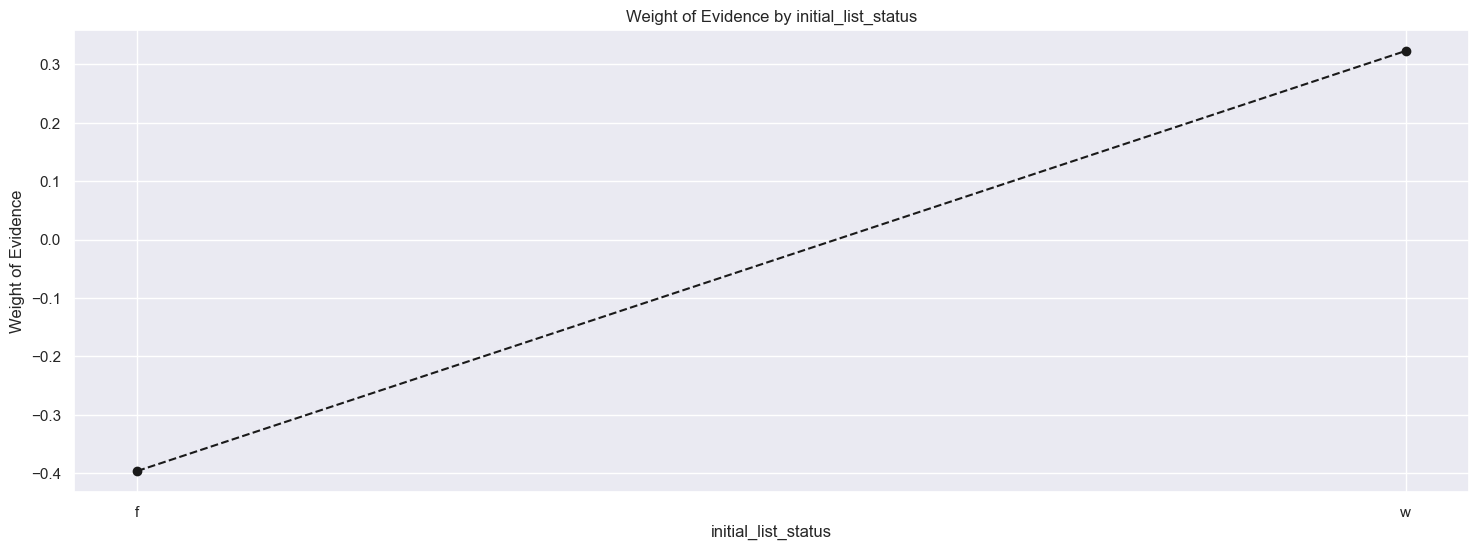

In [222]:
plot_by_woe(loan_data_temp)

### 6.2. Continuous variables 

#### 6.2.1. term_int

In [223]:
# hàm cho continuous không sort theo WoE vì muốn preserve the natural order
def woe_ordered_continuous(loan_data, continuous_variable_name, good_bad_variable_loan_data):
    loan_data = pd.concat([loan_data[continuous_variable_name], good_bad_variable_loan_data], axis=1)

    loan_data = pd.concat([loan_data.groupby(loan_data.columns.values[0], as_index=False)[loan_data.columns.values[1]].count(),
                    loan_data.groupby(loan_data.columns.values[0], as_index=False)[loan_data.columns.values[1]].mean()], axis=1)

    loan_data = loan_data.iloc[:, [0, 1, 3]]
    loan_data.columns = [loan_data.columns.values[0], 'n_obs', 'prop_good']

    loan_data['prop_n_obs'] = loan_data['n_obs'] / loan_data['n_obs'].sum()
    loan_data['n_good'] = loan_data['prop_good'] * loan_data['n_obs']
    loan_data['n_bad'] = (1 - loan_data['prop_good']) * loan_data['n_obs']

    loan_data['prop_n_good'] = loan_data['n_good'] / loan_data['n_good'].sum()
    loan_data['prop_n_bad'] = loan_data['n_bad'] / loan_data['n_bad'].sum()

    loan_data['WoE'] = np.log(loan_data['prop_n_good'] / loan_data['prop_n_bad'])

    #loan_data = loan_data.reset_index(drop=True)
    loan_data['diff_prop_good'] = loan_data['prop_n_good'].diff().abs()
    loan_data['diff_WoE'] = loan_data['WoE'].diff().abs()
    loan_data['IV'] = (loan_data['prop_n_good'] - loan_data['prop_n_bad']) * loan_data['WoE']
    loan_data['IV'] = loan_data['IV'].sum()

    return loan_data

In [224]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'term_int', df_targets_prepr)
loan_data_temp

,term_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,283172,0.983533,0.672467,278509.0,4663.0,0.673959,0.593937,0.126396,NaN,NaN,0.027678
1,60,137922,0.976885,0.327533,134734.0,3188.0,0.326041,0.406063,-0.219486,0.347919,0.345883,0.027678


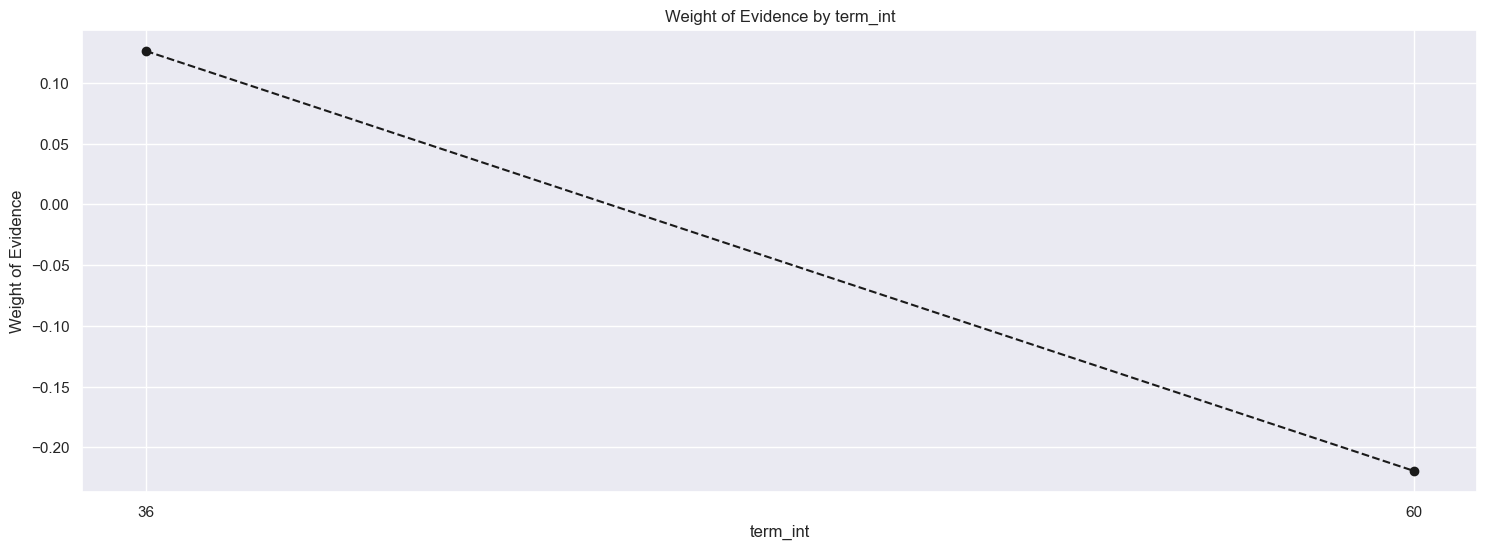

In [225]:
plot_by_woe(loan_data_temp)

In [226]:
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int'] == 36), 1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int'] == 60), 1, 0)

#### 6.2.2. emp_length

In [227]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'emp_length', df_targets_prepr)
loan_data_temp

,emp_length,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0,58157,0.977733,0.138109,56862.0,1295.0,0.137599,0.164947,-0.181278,NaN,NaN,0.019134
1,1,27473,0.977687,0.065242,26860.0,613.0,0.064998,0.078079,-0.183366,0.072601,0.002088,0.019134
2,2,37497,0.980932,0.089047,36782.0,715.0,0.089008,0.091071,-0.022914,0.024010,0.160453,0.019134
3,3,33430,0.980975,0.079388,32794.0,636.0,0.079358,0.081009,-0.020593,0.009650,0.002321,0.019134
4,4,24506,0.979678,0.058196,24008.0,498.0,0.058097,0.063431,-0.087853,0.021261,0.067260,0.019134
5,5,24930,0.980866,0.059203,24453.0,477.0,0.059173,0.060757,-0.026403,0.001077,0.061449,0.019134
6,6,16838,0.978976,0.039986,16484.0,354.0,0.039889,0.045090,-0.122546,0.019284,0.096143,0.019134
7,7,18414,0.979201,0.043729,18031.0,383.0,0.043633,0.048784,-0.111582,0.003744,0.010964,0.019134
8,8,21560,0.983905,0.051200,21213.0,347.0,0.051333,0.044198,0.149650,0.007700,0.261232,0.019134
9,9,16769,0.982289,0.039822,16472.0,297.0,0.039860,0.037830,0.052290,0.011473,0.097360,0.019134


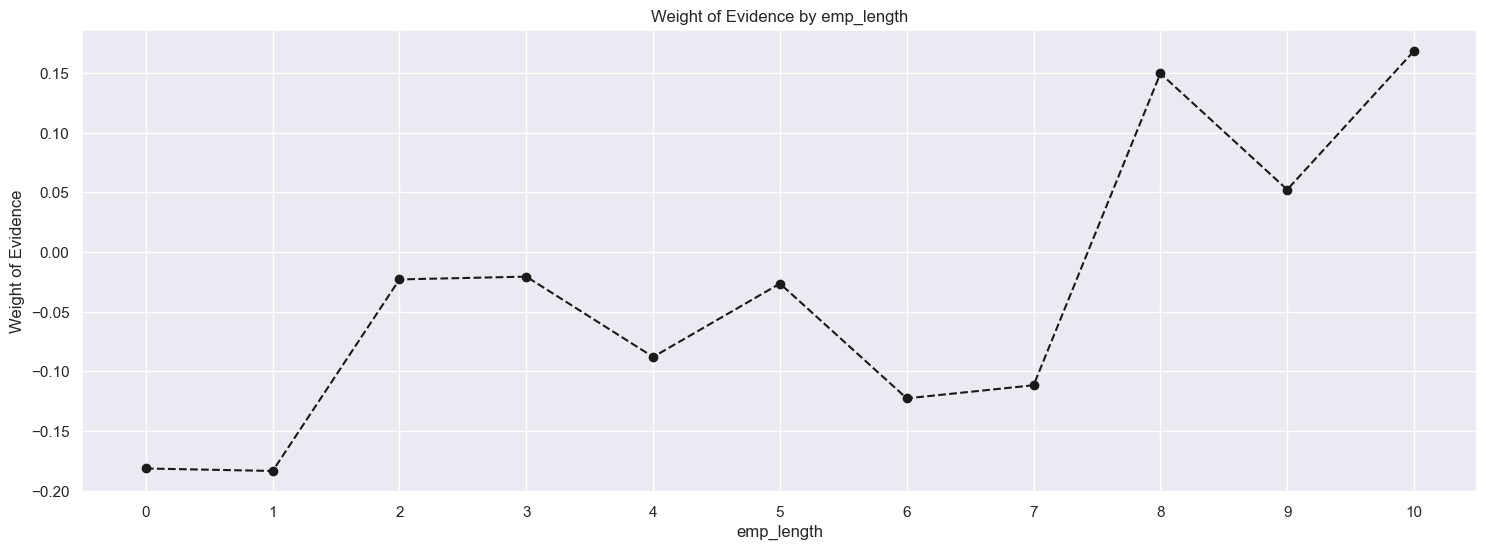

In [228]:
plot_by_woe(loan_data_temp)

In [229]:
df_inputs_prepr['emp_length:0'] = np.where(df_inputs_prepr['emp_length'].isin([0]), 1, 0)
df_inputs_prepr['emp_length:1'] = np.where(df_inputs_prepr['emp_length'].isin([1]), 1, 0)
df_inputs_prepr['emp_length:2-4'] = np.where(df_inputs_prepr['emp_length'].isin([2, 5]), 1, 0)
df_inputs_prepr['emp_length:5-6'] = np.where(df_inputs_prepr['emp_length'].isin([5, 6]), 1, 0)
df_inputs_prepr['emp_length:7-9'] = np.where(df_inputs_prepr['emp_length'].isin([7, 10]), 1, 0)
df_inputs_prepr['emp_length:10'] = np.where(df_inputs_prepr['emp_length'].isin([10]), 1, 0)

#### 6.2.3. mths_since_issue_d

In [230]:
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'], 50)

In [231]:
df_inputs_prepr['mths_since_issue_d_factor']

0         (23.989, 24.22]
1         (23.989, 24.22]
2         (23.989, 24.22]
3         (23.989, 24.22]
4         (23.989, 24.22]
               ...       
421089      (34.78, 35.0]
421090      (34.78, 35.0]
421091      (34.78, 35.0]
421092      (34.78, 35.0]
421093      (34.78, 35.0]
Name: mths_since_issue_d_factor, Length: 421094, dtype: category
Categories (50, interval[float64, right]): [(23.989, 24.22] < (24.22, 24.44] < (24.44, 24.66] < (24.66, 24.88] ... (34.12, 34.34] < (34.34, 34.56] < (34.56, 34.78] < (34.78, 35.0]]

In [232]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_issue_d_factor', df_targets_prepr)
loan_data_temp

,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(23.989, 24.22]",44342,1.000000,0.105302,44342.0,0.0,0.107302,0.000000,inf,NaN,NaN,inf
1,"(24.22, 24.44]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,"(24.44, 24.66]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(24.66, 24.88]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
4,"(24.88, 25.1]",37530,0.998082,0.089125,37458.0,72.0,0.090644,0.009171,2.290915,NaN,NaN,inf
5,"(25.1, 25.32]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
6,"(25.32, 25.54]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
7,"(25.54, 25.76]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(25.76, 25.98]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(25.98, 26.2]",48631,0.997327,0.115487,48501.0,130.0,0.117367,0.016558,1.958410,NaN,NaN,inf


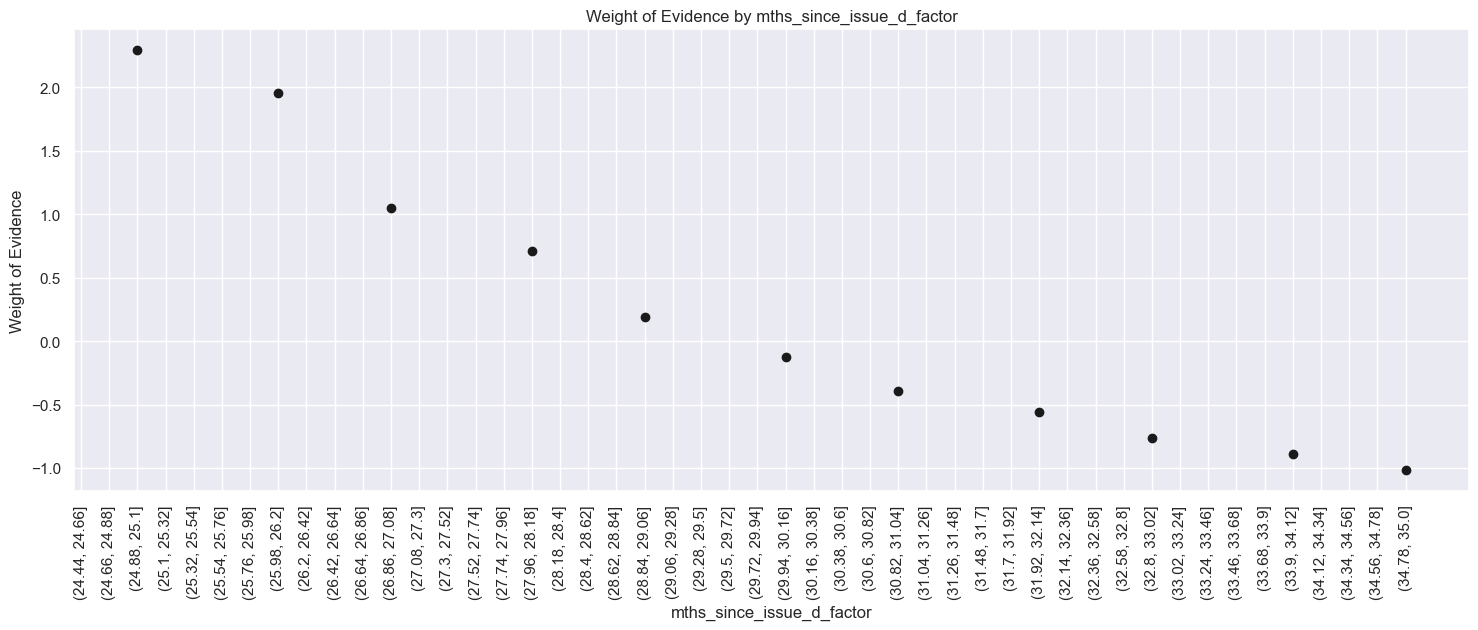

In [233]:
plot_by_woe(loan_data_temp, 90)

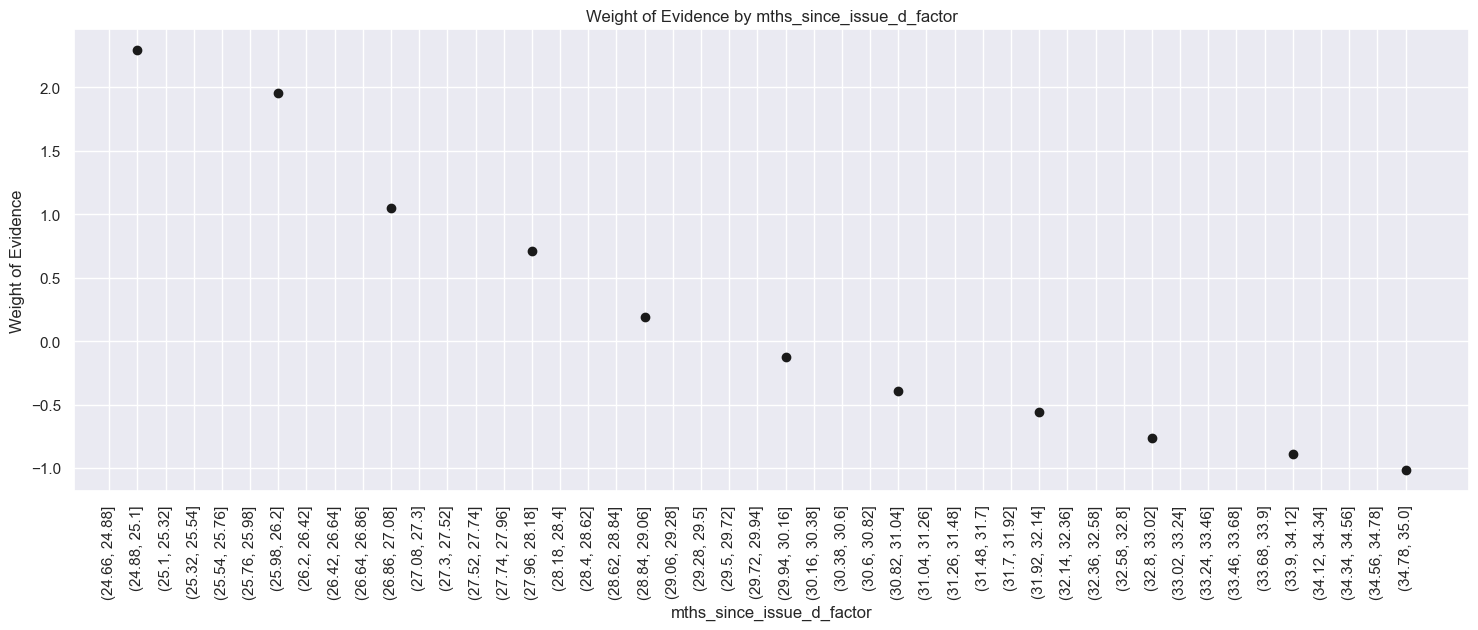

In [234]:
plot_by_woe(loan_data_temp.iloc[3: , :], 90)

In [235]:
df_inputs_prepr['mths_since_issue_d:<38'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38)), 1, 0)
df_inputs_prepr['mths_since_issue_d:38-39'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
df_inputs_prepr['mths_since_issue_d:40-41'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df_inputs_prepr['mths_since_issue_d:42-48'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs_prepr['mths_since_issue_d:49-52'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs_prepr['mths_since_issue_d:53-64'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs_prepr['mths_since_issue_d:65-84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
df_inputs_prepr['mths_since_issue_d:>84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(85, int(df_inputs_prepr['mths_since_issue_d'].max()))), 1, 0)

#### 6.2.4. int_rate

In [236]:
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)

In [237]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'int_rate_factor', df_targets_prepr)
loan_data_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.296, 5.793]",9651,0.999689,0.022919,9648.0,3.0,0.023347,0.000382,4.112499,NaN,NaN,inf
1,"(5.793, 6.267]",10214,0.997259,0.024256,10186.0,28.0,0.024649,0.003566,1.933170,0.001302,2.179329,inf
2,"(6.267, 6.74]",6530,0.994793,0.015507,6496.0,34.0,0.015720,0.004331,1.289186,0.008929,0.643984,inf
3,"(6.74, 7.214]",12488,0.995275,0.029656,12429.0,59.0,0.030077,0.007515,1.386855,0.014357,0.097669,inf
4,"(7.214, 7.687]",11416,0.997985,0.027110,11393.0,23.0,0.027570,0.002930,2.241865,0.002507,0.855010,inf
5,"(7.687, 8.16]",20636,0.995687,0.049006,20547.0,89.0,0.049721,0.011336,1.478439,0.022152,0.763426,inf
6,"(8.16, 8.634]",22498,0.994133,0.053428,22366.0,132.0,0.054123,0.016813,1.169100,0.004402,0.309339,inf
7,"(8.634, 9.107]",2020,0.979703,0.004797,1979.0,41.0,0.004789,0.005222,-0.086620,0.049334,1.255720,inf
8,"(9.107, 9.581]",22171,0.992783,0.052651,22011.0,160.0,0.053264,0.020380,0.960729,0.048475,1.047349,inf
9,"(9.581, 10.054]",22364,0.993829,0.053109,22226.0,138.0,0.053784,0.017577,1.118369,0.000520,0.157641,inf


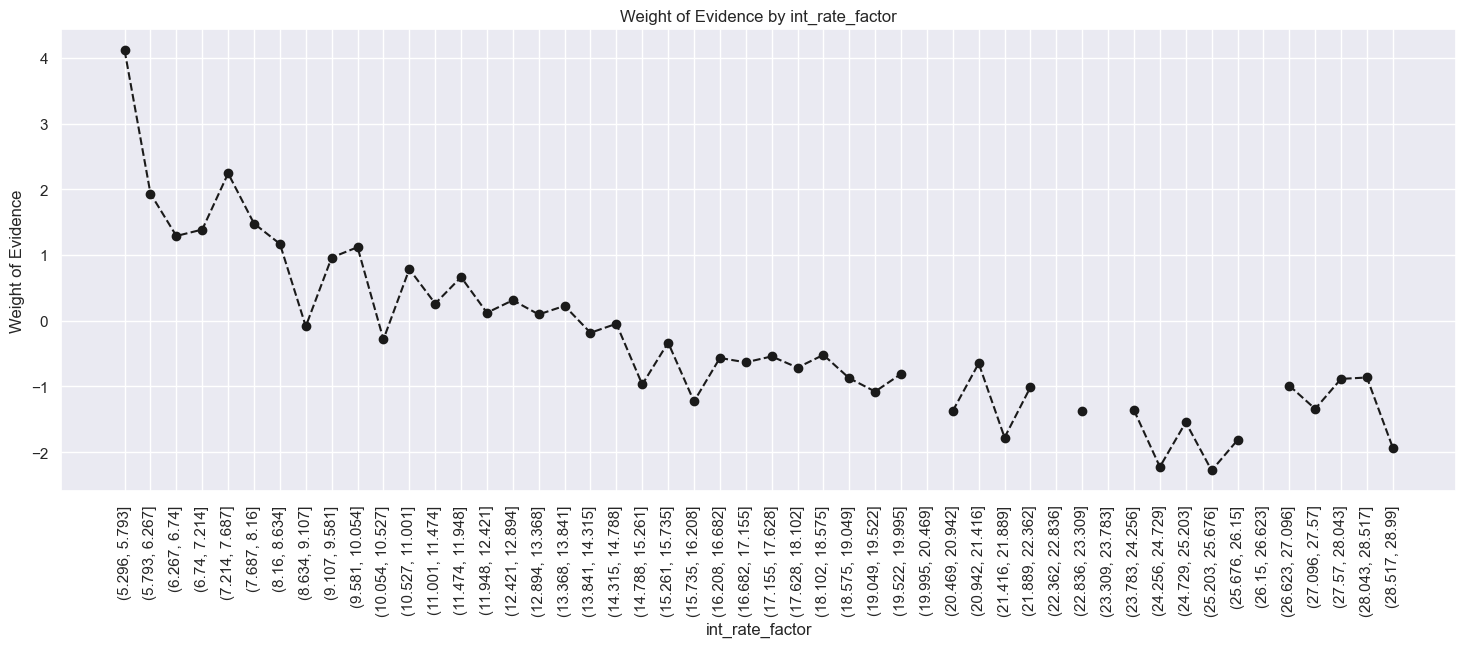

In [238]:
plot_by_woe(loan_data_temp, 90)

In [239]:
df_inputs_prepr['int_rate:<9.548'] = np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:12.025-15.74'] = np.where((df_inputs_prepr['int_rate'] > 12.025) & (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate:15.74-20.281'] = np.where((df_inputs_prepr['int_rate'] > 15.74) & (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate:>20.281'] = np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)

#### 6.2.5. funded_amount

In [240]:
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)

In [241]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'funded_amnt_factor', df_targets_prepr)
loan_data_temp

,funded_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(966.0, 1680.0]",3391,0.982306,0.008053,3331.0,60.0,0.008061,0.007642,0.053288,NaN,NaN,0.027107
1,"(1680.0, 2360.0]",3751,0.981338,0.008908,3681.0,70.0,0.008908,0.008916,-0.000950,0.000847,0.054239,0.027107
2,"(2360.0, 3040.0]",8134,0.981190,0.019316,7981.0,153.0,0.019313,0.019488,-0.009014,0.010405,0.008063,0.027107
3,"(3040.0, 3720.0]",5133,0.983246,0.012190,5047.0,86.0,0.012213,0.010954,0.108807,0.007100,0.117821,0.027107
4,"(3720.0, 4400.0]",7315,0.980041,0.017371,7169.0,146.0,0.017348,0.018596,-0.069480,0.005135,0.178287,0.027107
5,"(4400.0, 5080.0]",18150,0.982479,0.043102,17832.0,318.0,0.043151,0.040504,0.063304,0.025803,0.132784,0.027107
6,"(5080.0, 5760.0]",5617,0.984867,0.013339,5532.0,85.0,0.013387,0.010827,0.212259,0.029765,0.148955,0.027107
7,"(5760.0, 6440.0]",16224,0.982618,0.038528,15942.0,282.0,0.038578,0.035919,0.071410,0.025191,0.140848,0.027107
8,"(6440.0, 7120.0]",10565,0.982489,0.025089,10380.0,185.0,0.025118,0.023564,0.063885,0.013459,0.007525,0.027107
9,"(7120.0, 7800.0]",8423,0.980173,0.020003,8256.0,167.0,0.019979,0.021271,-0.062693,0.005140,0.126579,0.027107


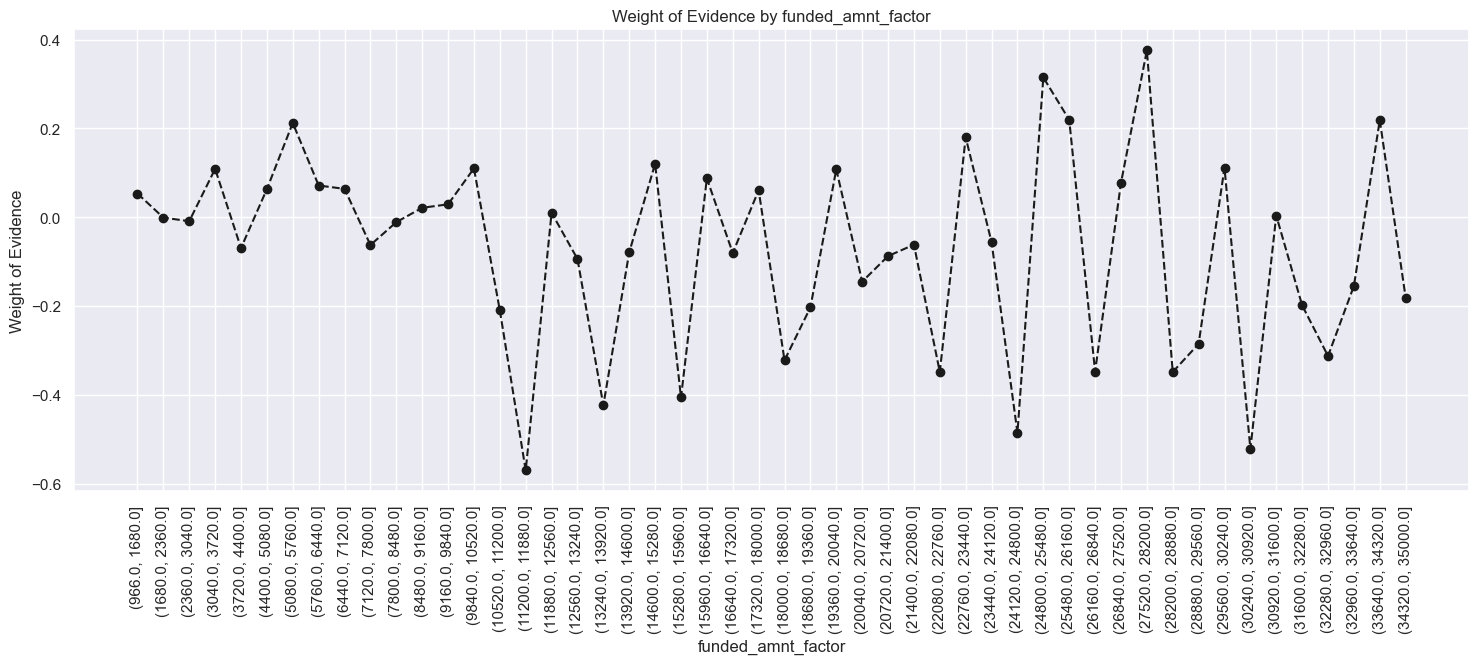

In [242]:
plot_by_woe(loan_data_temp, 90)

#### 6.2.6. mths_since_earliest_cr_line

In [243]:
df_inputs_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(df_inputs_prepr['mths_since_earliest_cr_line'], 20)

In [244]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_earliest_cr_line_factor', df_targets_prepr)
loan_data_temp

,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(60.174, 102.3]",16508,0.975345,0.039203,16101.0,407.0,0.038963,0.051841,-0.285571,NaN,NaN,inf
1,"(102.3, 143.6]",40588,0.974919,0.096387,39570.0,1018.0,0.095755,0.129665,-0.303164,0.056792,0.017592,inf
2,"(143.6, 184.9]",88609,0.979122,0.210426,86759.0,1850.0,0.209947,0.235639,-0.115446,0.114192,0.187717,inf
3,"(184.9, 226.2]",93973,0.981324,0.223164,92218.0,1755.0,0.223157,0.223538,-0.001708,0.013210,0.113738,inf
4,"(226.2, 267.5]",63453,0.983200,0.150686,62387.0,1066.0,0.150969,0.135779,0.106049,0.072188,0.107757,inf
5,"(267.5, 308.8]",43960,0.984668,0.104395,43286.0,674.0,0.104747,0.085849,0.198960,0.046222,0.092911,inf
6,"(308.8, 350.1]",28609,0.985284,0.067940,28188.0,421.0,0.068212,0.053624,0.240624,0.036535,0.041664,inf
7,"(350.1, 391.4]",19316,0.985401,0.045871,19034.0,282.0,0.046060,0.035919,0.248680,0.022152,0.008056,inf
8,"(391.4, 432.7]",12007,0.986091,0.028514,11840.0,167.0,0.028651,0.021271,0.297850,0.017409,0.049170,inf
9,"(432.7, 474.0]",5999,0.986498,0.014246,5918.0,81.0,0.014321,0.010317,0.327910,0.014331,0.030060,inf


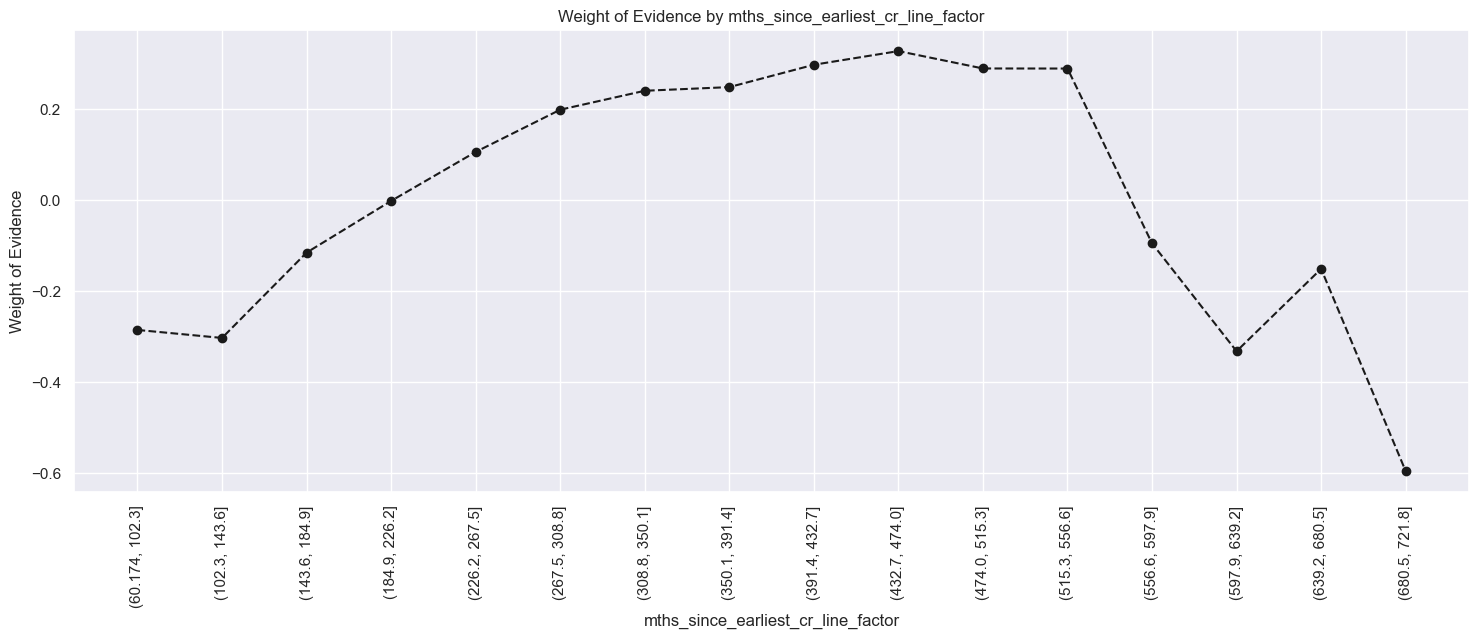

In [245]:
plot_by_woe(loan_data_temp, 90)

In [246]:
df_inputs_prepr['mths_since_earliest_cr_line:<133.05'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin([-0.887, 133.05]), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:133.05- 266.1'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin([133.05,  266.1]), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:266.1-487.85'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin([266.1, 487.85]), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:487.85-665.25'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin([487.85, 665.25]), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:665.25-798.3'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin([665.25, 798.3]), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:>798.3'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin([798.3, 887.0]), 1, 0)

#### 6.2.7.installment

In [247]:
df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)

In [248]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'installment_factor', df_targets_prepr)
loan_data_temp

,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(28.705, 58.427]",3506,0.982886,0.008326,3446.0,60.0,0.008339,0.007642,0.087230,NaN,NaN,inf
1,"(58.427, 86.734]",5832,0.981310,0.013850,5723.0,109.0,0.013849,0.013884,-0.002494,0.005510,0.089724,inf
2,"(86.734, 115.04]",8123,0.983134,0.019290,7986.0,137.0,0.019325,0.017450,0.102069,0.005476,0.104564,inf
3,"(115.04, 143.347]",9139,0.982383,0.021703,8978.0,161.0,0.021726,0.020507,0.057733,0.002401,0.044336,inf
4,"(143.347, 171.654]",17953,0.984459,0.042634,17674.0,279.0,0.042769,0.035537,0.185243,0.021043,0.127510,inf
5,"(171.654, 199.961]",15515,0.985691,0.036845,15293.0,222.0,0.037007,0.028277,0.269078,0.005762,0.083835,inf
6,"(199.961, 228.268]",16515,0.982864,0.039219,16232.0,283.0,0.039280,0.036046,0.085898,0.002272,0.183180,inf
7,"(228.268, 256.574]",22043,0.983033,0.052347,21669.0,374.0,0.052436,0.047637,0.095987,0.013157,0.010089,inf
8,"(256.574, 284.881]",25323,0.980966,0.060136,24841.0,482.0,0.060112,0.061393,-0.021088,0.007676,0.117075,inf
9,"(284.881, 313.188]",24135,0.980443,0.057315,23663.0,472.0,0.057262,0.060120,-0.048706,0.002851,0.027618,inf


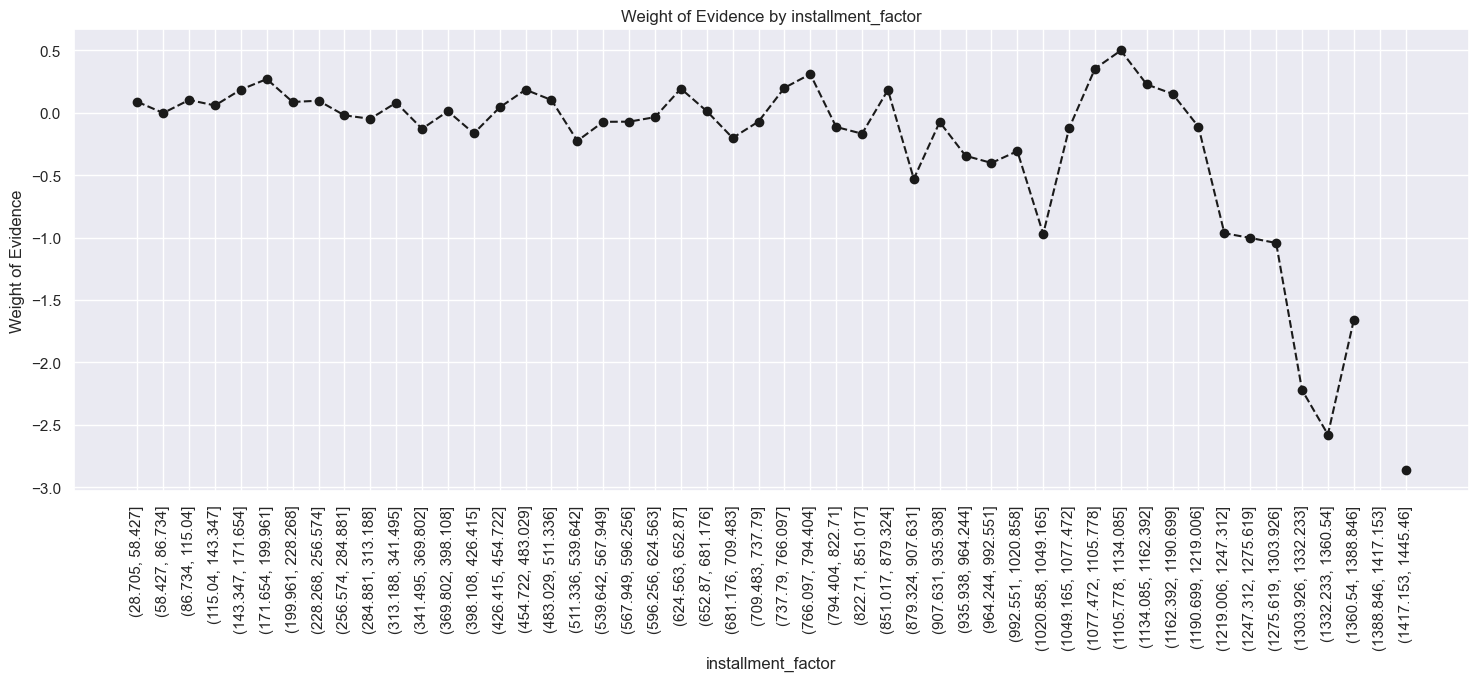

In [249]:
plot_by_woe(loan_data_temp, 90)

#### 6.2.8. delinq_2yrs

Quantile Binning 

In [250]:
df_inputs_prepr['delinq_2yrs'].unique()

array([ 0.,  2.,  1.,  3.,  4.,  6.,  5., 15.,  7.,  9., 10.,  8., 11.,
       13., 14., 12., 30., 18., 16., 17., 26., 20., 19., 22., 27., 39.])

In [251]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'delinq_2yrs', df_targets_prepr)
loan_data_temp

,delinq_2yrs,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,334007,0.981812,0.793189,327932.0,6075.0,0.793557,0.773787,0.025229,NaN,NaN,inf
1,1.0,57000,0.980246,0.135362,55874.0,1126.0,0.135209,0.143421,-0.058967,0.658349,0.084197,inf
2,2.0,17241,0.979120,0.040943,16881.0,360.0,0.040850,0.045854,-0.115555,0.094359,0.056588,inf
3,3.0,6293,0.976800,0.014944,6147.0,146.0,0.014875,0.018596,-0.223282,0.025975,0.107727,inf
4,4.0,2949,0.976263,0.007003,2879.0,70.0,0.006967,0.008916,-0.246692,0.007908,0.023410,inf
5,5.0,1475,0.978305,0.003503,1443.0,32.0,0.003492,0.004076,-0.154651,0.003475,0.092041,inf
6,6.0,842,0.980998,0.002000,826.0,16.0,0.001999,0.002038,-0.019389,0.001493,0.135262,inf
7,7.0,438,0.984018,0.001040,431.0,7.0,0.001043,0.000892,0.156803,0.000956,0.176192,inf
8,8.0,284,0.982394,0.000674,279.0,5.0,0.000675,0.000637,0.058379,0.000368,0.098424,inf
9,9.0,173,0.976879,0.000411,169.0,4.0,0.000409,0.000509,-0.219791,0.000266,0.278170,inf


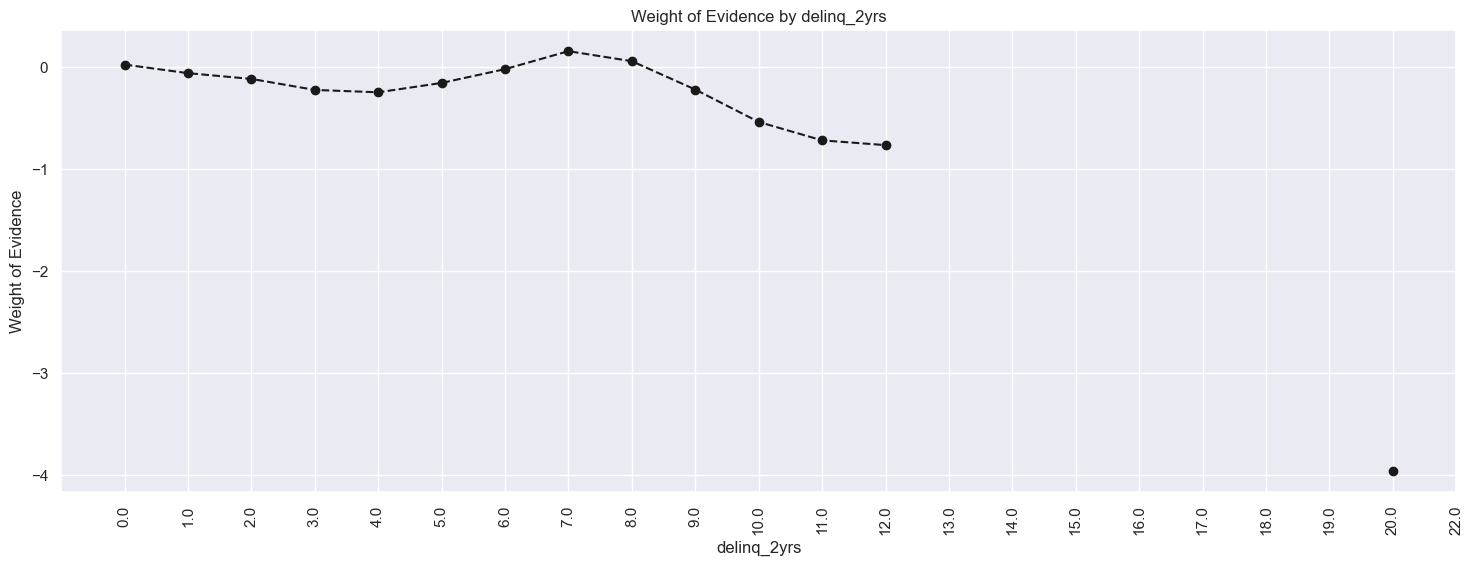

In [252]:
plot_by_woe(loan_data_temp, 90)

In [253]:
df_inputs_prepr['delinq_2yrs:0'] = np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs:1-5'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & (df_inputs_prepr['delinq_2yrs'] <= 5), 1, 0)
df_inputs_prepr['delinq_2yrs:>=6'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 6), 1, 0)

#### 6.2.9. inq_last_6mths

In [254]:
df_inputs_prepr['inq_last_6mths'].unique()

array([0., 1., 3., 4., 2., 5., 6.])

In [255]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'inq_last_6mths', df_targets_prepr)
loan_data_temp

,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,256407,0.984813,0.608907,252513.0,3894.0,0.611052,0.495988,0.208631,NaN,NaN,0.06837
1,1.0,111346,0.978571,0.264421,108960.0,2386.0,0.263671,0.303910,-0.142032,0.347382,0.350663,0.06837
2,2.0,36292,0.973438,0.086185,35328.0,964.0,0.085490,0.122787,-0.362055,0.178181,0.220023,0.06837
3,3.0,12272,0.964635,0.029143,11838.0,434.0,0.028647,0.055280,-0.657369,0.056843,0.295314,0.06837
4,4.0,3517,0.966164,0.008352,3398.0,119.0,0.008223,0.015157,-0.611576,0.020424,0.045793,0.06837
5,5.0,1217,0.957272,0.002890,1165.0,52.0,0.002819,0.006623,-0.854162,0.005404,0.242586,0.06837
6,6.0,43,0.953488,0.000102,41.0,2.0,0.000099,0.000255,-0.942970,0.002720,0.088808,0.06837


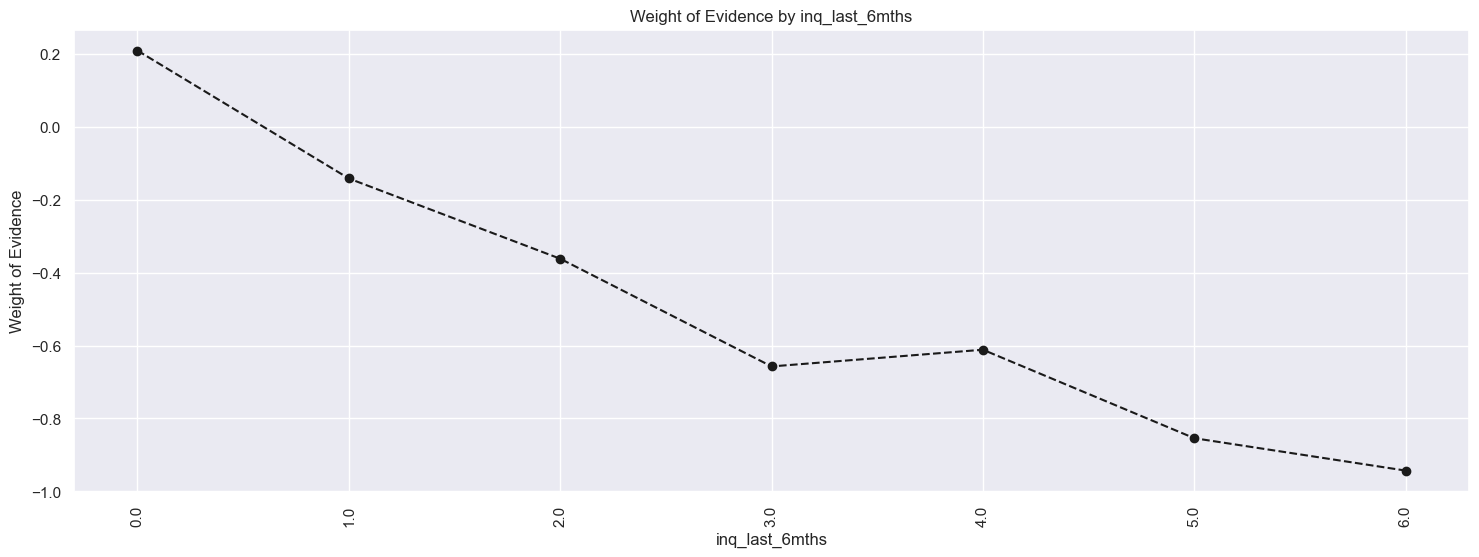

In [256]:
plot_by_woe(loan_data_temp, 90)

In [257]:
df_inputs_prepr['inq_last_6mths:0'] = np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths:1'] = np.where((df_inputs_prepr['inq_last_6mths'] == 1), 1, 0)
df_inputs_prepr['inq_last_6mths:2-6'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 2) & (df_inputs_prepr['inq_last_6mths'] <= 6), 1, 0)
df_inputs_prepr['inq_last_6mths:>=7'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 7), 1, 0)

#### 6.2.10. open_acc

In [258]:
df_inputs_prepr['open_acc'].unique()

array([17., 15.,  6., 10.,  7.,  9.,  5., 30., 12., 21., 18., 13.,  8.,
       16.,  4., 11., 33., 14.,  3., 28., 19., 24., 20., 22., 29., 27.,
       23., 25., 26., 34., 46.,  2., 35., 32., 40., 55., 37., 39., 31.,
       36., 38., 47., 44.,  1., 42., 41., 43., 52., 45., 53., 65., 51.,
       58., 67., 49., 50., 57., 48., 66., 54., 68., 61., 70., 60., 56.,
       82., 63., 59., 64., 62., 79., 74., 90.])

In [259]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'open_acc', df_targets_prepr)
loan_data_temp

,open_acc,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1.0,90,0.988889,0.000214,89.0,1.0,0.000215,0.000127,0.525241,NaN,NaN,inf
1,2.0,986,0.972617,0.002342,959.0,27.0,0.002321,0.003439,-0.393341,0.002105,0.918582,inf
2,3.0,4119,0.984462,0.009782,4055.0,64.0,0.009813,0.008152,0.185428,0.007492,0.578769,inf
3,4.0,10779,0.978941,0.025598,10552.0,227.0,0.025535,0.028914,-0.124274,0.015722,0.309702,inf
4,5.0,18222,0.980738,0.043273,17871.0,351.0,0.043246,0.044708,-0.033247,0.017711,0.091028,inf
5,6.0,25117,0.980491,0.059647,24627.0,490.0,0.059594,0.062412,-0.046202,0.016349,0.012955,inf
6,7.0,30294,0.981283,0.071941,29727.0,567.0,0.071936,0.072220,-0.003943,0.012341,0.042258,inf
7,8.0,34685,0.980885,0.082369,34022.0,663.0,0.082329,0.084448,-0.025407,0.010393,0.021464,inf
8,9.0,36266,0.981801,0.086123,35606.0,660.0,0.086162,0.084066,0.024635,0.003833,0.050042,inf
9,10.0,35809,0.980647,0.085038,35116.0,693.0,0.084977,0.088269,-0.038013,0.001186,0.062647,inf


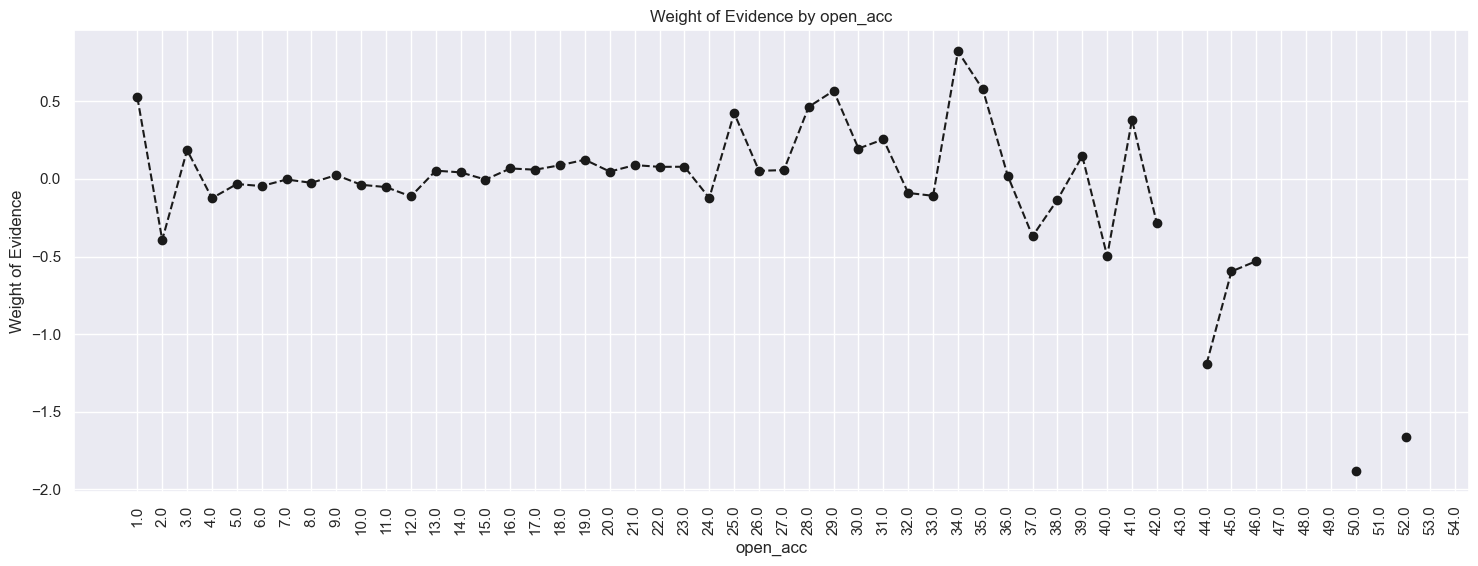

In [260]:
plot_by_woe(loan_data_temp, 90)

In [261]:
df_inputs_prepr['open_acc:0-3'] = np.where((df_inputs_prepr['open_acc'] >= 0) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc:4-13'] = np.where((df_inputs_prepr['open_acc'] >= 4) & (df_inputs_prepr['open_acc'] <= 13), 1, 0)
df_inputs_prepr['open_acc:13-25'] = np.where((df_inputs_prepr['open_acc'] >= 13) & (df_inputs_prepr['open_acc'] <= 25), 1, 0)
df_inputs_prepr['open_acc:26-33'] = np.where((df_inputs_prepr['open_acc'] >= 26) & (df_inputs_prepr['open_acc'] <= 33), 1, 0)
df_inputs_prepr['open_acc:>=33'] = np.where((df_inputs_prepr['open_acc'] >= 34), 1, 0)

#### 6.2.11. pub_rec

In [262]:
df_inputs_prepr['pub_rec'].unique()

array([ 0.,  2.,  1.,  3.,  5.,  4., 11.,  7.,  6.,  9.,  8., 10., 23.,
       12., 15., 26., 17., 13., 28., 20., 86., 18., 21., 14., 16., 19.,
       49., 22.])

In [263]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'pub_rec', df_targets_prepr)
loan_data_temp

,pub_rec,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,346679,0.981594,0.823282,340298.0,6381.0,0.823482,0.812763,0.013102,NaN,NaN,inf
1,1.0,60215,0.979972,0.142997,59009.0,1206.0,0.142795,0.153611,-0.073014,0.680687,0.086116,inf
2,2.0,9230,0.982124,0.021919,9065.0,165.0,0.021936,0.021016,0.042836,0.120859,0.115850,inf
3,3.0,2876,0.979833,0.006830,2818.0,58.0,0.006819,0.007388,-0.080055,0.015117,0.122891,inf
4,4.0,1044,0.977011,0.002479,1020.0,24.0,0.002468,0.003057,-0.213891,0.004351,0.133836,inf
5,5.0,481,0.979210,0.001142,471.0,10.0,0.001140,0.001274,-0.111122,0.001329,0.102769,inf
6,6.0,249,0.983936,0.000591,245.0,4.0,0.000593,0.000509,0.151569,0.000547,0.262691,inf
7,7.0,108,1.000000,0.000256,108.0,0.0,0.000261,0.000000,inf,0.000332,inf,inf
8,8.0,84,1.000000,0.000199,84.0,0.0,0.000203,0.000000,inf,0.000058,NaN,inf
9,9.0,34,0.970588,0.000081,33.0,1.0,0.000080,0.000127,-0.466887,0.000123,inf,inf


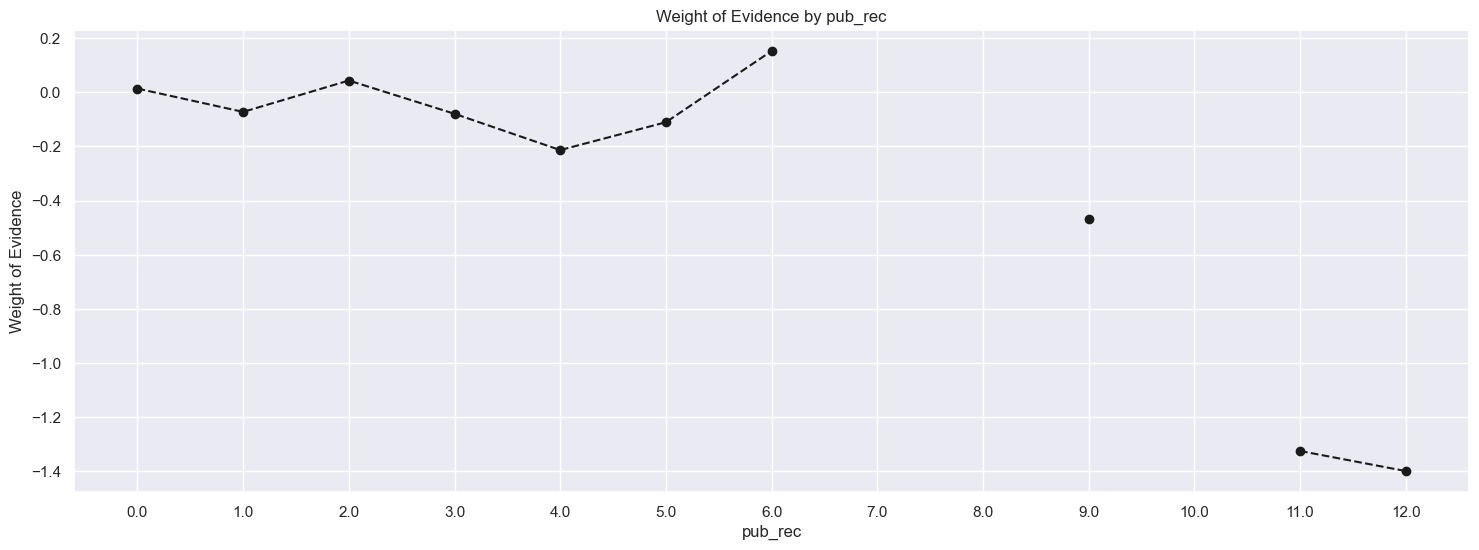

In [264]:
plot_by_woe(loan_data_temp)

In [265]:
df_inputs_prepr['pub_rec:0'] = np.where((df_inputs_prepr['pub_rec'] == 0), 1, 0)
df_inputs_prepr['pub_rec:1'] = np.where((df_inputs_prepr['pub_rec'] == 1), 1, 0)
df_inputs_prepr['pub_rec:2-3'] = np.where((df_inputs_prepr['pub_rec'] >= 2) & (df_inputs_prepr['pub_rec'] <= 3), 1, 0)
df_inputs_prepr['pub_rec:>=4'] = np.where((df_inputs_prepr['pub_rec'] >= 4), 1, 0)

#### 6.2.12. total_acc

In [266]:
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'], 10)

In [267]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'total_acc_factor', df_targets_prepr)
loan_data_temp

,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(3.835, 20.5]",161492,0.980315,0.383506,158313.0,3179.0,0.383099,0.404917,-0.055387,NaN,NaN,inf
1,"(20.5, 37.0]",195831,0.981923,0.465053,192291.0,3540.0,0.465322,0.450898,0.031488,0.082223,0.086876,inf
2,"(37.0, 53.5]",53019,0.982440,0.125908,52088.0,931.0,0.126047,0.118584,0.061036,0.339275,0.029547,inf
3,"(53.5, 70.0]",9328,0.982526,0.022152,9165.0,163.0,0.022178,0.020762,0.066002,0.103869,0.004966,inf
4,"(70.0, 86.5]",1166,0.971698,0.002769,1133.0,33.0,0.002742,0.004203,-0.427278,0.019437,0.493280,inf
5,"(86.5, 103.0]",210,0.985714,0.000499,207.0,3.0,0.000501,0.000382,0.270712,0.002241,0.697990,inf
6,"(103.0, 119.5]",33,0.939394,0.000078,31.0,2.0,0.000075,0.000255,-1.222555,0.000426,1.493266,inf
7,"(119.5, 136.0]",8,1.000000,0.000019,8.0,0.0,0.000019,0.000000,inf,0.000056,inf,inf
8,"(136.0, 152.5]",5,1.000000,0.000012,5.0,0.0,0.000012,0.000000,inf,0.000007,NaN,inf
9,"(152.5, 169.0]",2,1.000000,0.000005,2.0,0.0,0.000005,0.000000,inf,0.000007,NaN,inf


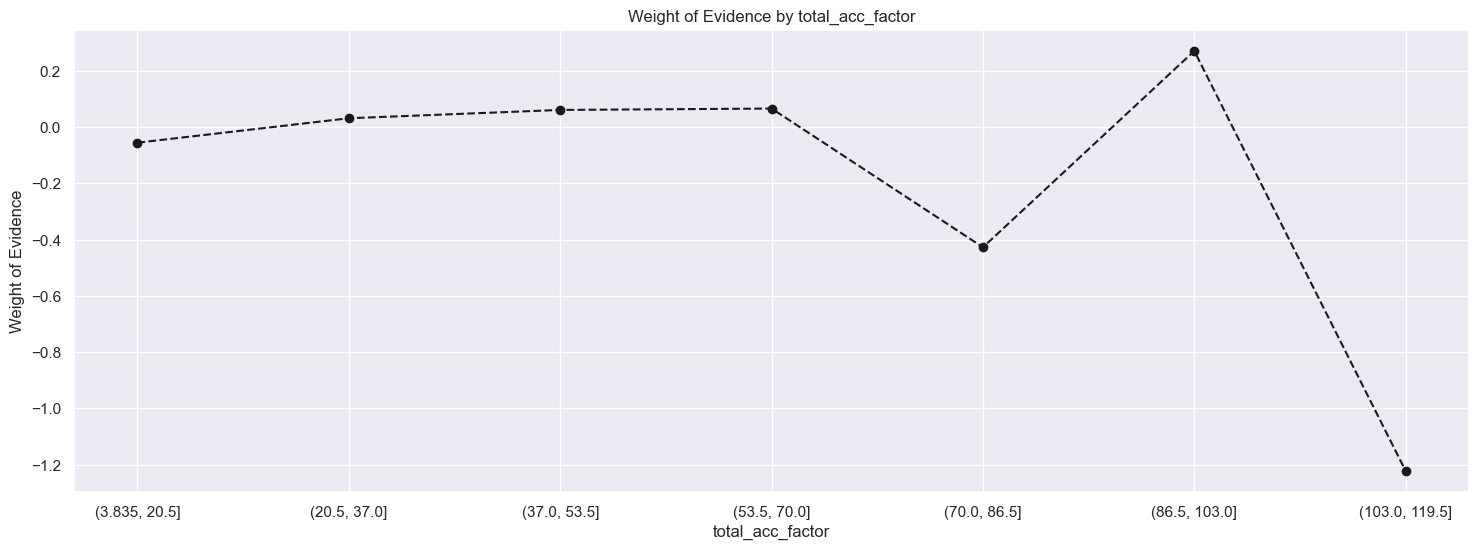

In [268]:
plot_by_woe(loan_data_temp)

In [269]:
df_inputs_prepr['total_acc:<15.0'] = np.where(df_inputs_prepr['total_acc_factor'].isin([-0.15, 15]), 1, 0)
df_inputs_prepr['total_acc:15- 30'] = np.where(df_inputs_prepr['total_acc_factor'].isin([15,  30]), 1, 0)
df_inputs_prepr['total_acc:30-60'] = np.where(df_inputs_prepr['total_acc_factor'].isin([30, 60]), 1, 0)
df_inputs_prepr['total_acc:>60'] = np.where(df_inputs_prepr['total_acc_factor'].isin([60, 150]), 1, 0)

#### 6.2.13. acc_now_delinq

In [270]:
df_inputs_prepr['acc_now_delinq'].unique()

array([ 0.,  1.,  2.,  4.,  3.,  5.,  6., 14.])

In [271]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'acc_now_delinq', df_targets_prepr)
loan_data_temp

,acc_now_delinq,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,418712,0.981424,0.994343,410934.0,7778.0,0.994412,0.990702,0.003738,NaN,NaN,inf
1,1.0,2243,0.971021,0.005327,2178.0,65.0,0.005271,0.008279,-0.451620,0.989142,0.455358,inf
2,2.0,116,0.939655,0.000275,109.0,7.0,0.000264,0.000892,-1.217957,0.005007,0.766337,inf
3,3.0,17,1.000000,0.000040,17.0,0.0,0.000041,0.000000,inf,0.000223,inf,inf
4,4.0,3,0.666667,0.000007,2.0,1.0,0.000005,0.000127,-3.270248,0.000036,inf,inf
5,5.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.000002,inf,inf
6,6.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.000000,NaN,inf
7,14.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.000000,NaN,inf


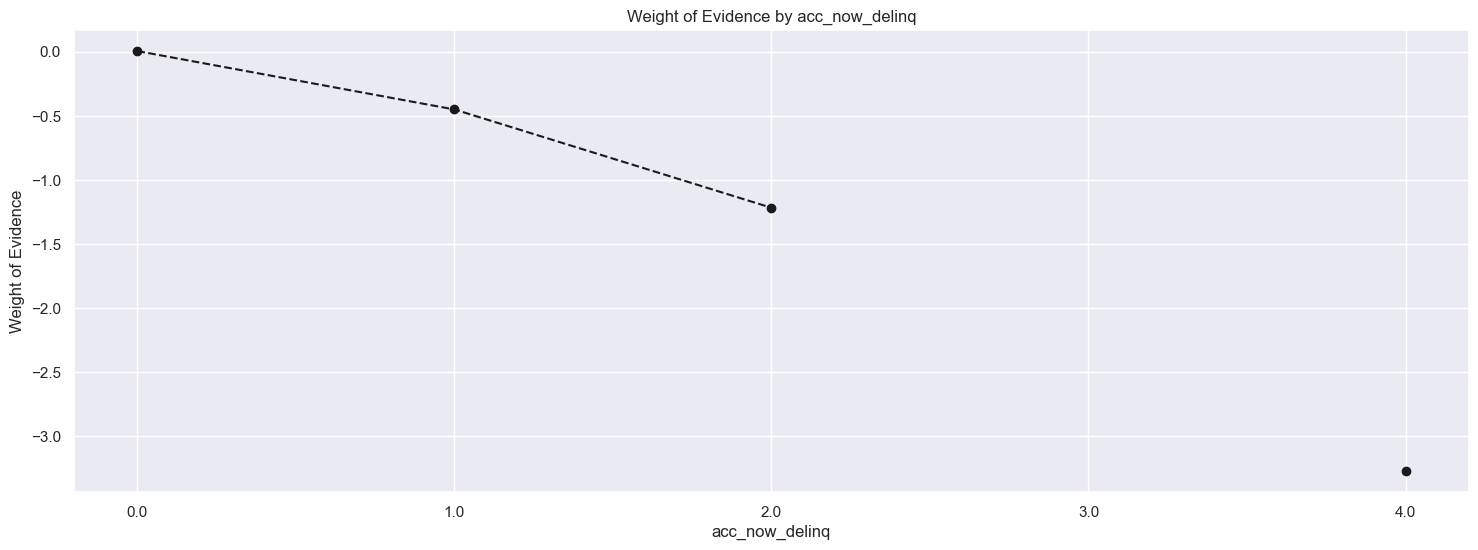

In [272]:
plot_by_woe(loan_data_temp)

In [273]:
df_inputs_prepr['acc_now_delinq:0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq:>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

#### 6.2.14. total_rev_hi_lim

In [274]:
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 2000)
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'total_rev_hi_lim_factor', df_targets_prepr)
loan_data_temp

,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9999.999, 5000.0]",12981,0.971266,0.030827,12608.0,373.0,0.030510,0.047510,-0.442886,NaN,NaN,inf
1,"(5000.0, 9999.999]",42858,0.974801,0.101778,41778.0,1080.0,0.101098,0.137562,-0.307986,0.070588,0.134900,inf
2,"(9999.999, 14999.998]",56173,0.977658,0.133398,54918.0,1255.0,0.132895,0.159852,-0.184689,0.031797,0.123297,inf
3,"(14999.998, 19999.998]",54873,0.979498,0.130311,53748.0,1125.0,0.130064,0.143294,-0.096871,0.002831,0.087818,inf
4,"(19999.998, 24999.997]",46739,0.981942,0.110994,45895.0,844.0,0.111061,0.107502,0.032564,0.019003,0.129436,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(9974999.002, 9979999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1996,"(9979999.002, 9984999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1997,"(9984999.002, 9989999.001]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1998,"(9989999.001, 9994999.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


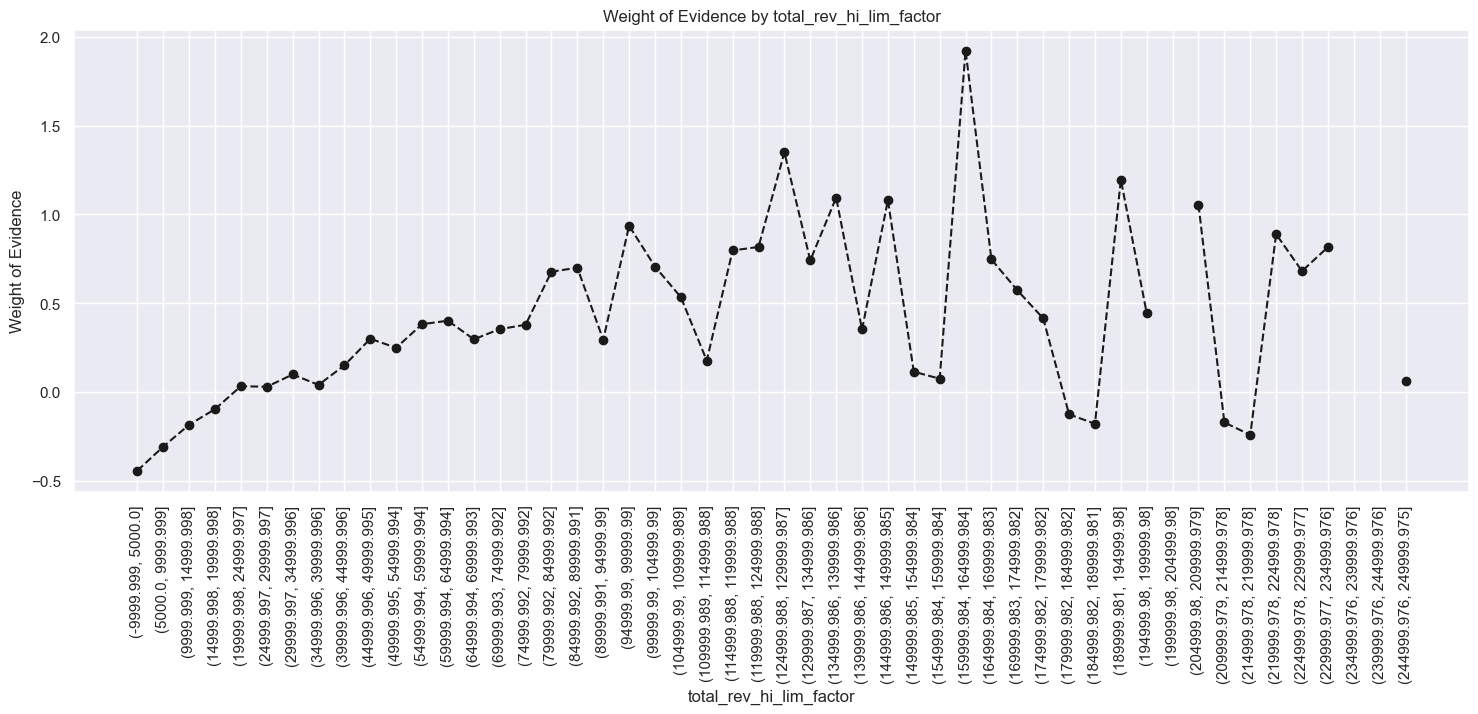

In [275]:
plot_by_woe(loan_data_temp.iloc[: 50, : ], 90)

In [276]:
df_inputs_prepr['total_rev_hi_lim:<=5K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 5000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:5K-10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 5000) & (df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) & (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:40K-55K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) & (df_inputs_prepr['total_rev_hi_lim'] <= 55000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)

#### 6.2.15 annual_inc

In [277]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 50)
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
loan_data_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9500.0, 190000.0]",409693,0.981193,0.972925,401988.0,7705.0,0.972764,0.981404,-0.008842,NaN,NaN,inf
1,"(190000.0, 380000.0]",10007,0.986609,0.023764,9873.0,134.0,0.023892,0.017068,0.336324,0.948873,0.345166,inf
2,"(380000.0, 570000.0]",943,0.990456,0.002239,934.0,9.0,0.002260,0.001146,0.678857,0.021631,0.342533,inf
3,"(570000.0, 760000.0]",257,1.000000,0.000610,257.0,0.0,0.000622,0.000000,inf,0.001638,inf,inf
4,"(760000.0, 950000.0]",70,1.000000,0.000166,70.0,0.0,0.000169,0.000000,inf,0.000453,NaN,inf
5,"(950000.0, 1140000.0]",43,1.000000,0.000102,43.0,0.0,0.000104,0.000000,inf,0.000065,NaN,inf
6,"(1140000.0, 1330000.0]",20,0.950000,0.000047,19.0,1.0,0.000046,0.000127,-1.018956,0.000058,inf,inf
7,"(1330000.0, 1520000.0]",14,1.000000,0.000033,14.0,0.0,0.000034,0.000000,inf,0.000012,inf,inf
8,"(1520000.0, 1710000.0]",3,0.666667,0.000007,2.0,1.0,0.000005,0.000127,-3.270248,0.000029,inf,inf
9,"(1710000.0, 1900000.0]",5,1.000000,0.000012,5.0,0.0,0.000012,0.000000,inf,0.000007,inf,inf


In [278]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 100)
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
loan_data_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9500.0, 95000.0]",325648,0.980203,0.773338,319201.0,6447.0,0.772429,0.821169,-0.061189,NaN,NaN,inf
1,"(95000.0, 190000.0]",84045,0.985032,0.199587,82787.0,1258.0,0.200335,0.160234,0.223353,0.572094,0.284542,inf
2,"(190000.0, 285000.0]",8186,0.986196,0.019440,8073.0,113.0,0.019536,0.014393,0.305498,0.180799,0.082145,inf
3,"(285000.0, 380000.0]",1821,0.988468,0.004324,1800.0,21.0,0.004356,0.002675,0.487625,0.015180,0.182127,inf
4,"(380000.0, 475000.0]",652,0.990798,0.001548,646.0,6.0,0.001563,0.000764,0.715645,0.002793,0.228021,inf
5,"(475000.0, 570000.0]",291,0.989691,0.000691,288.0,3.0,0.000697,0.000382,0.600953,0.000866,0.114692,inf
6,"(570000.0, 665000.0]",165,1.000000,0.000392,165.0,0.0,0.000399,0.000000,inf,0.000298,inf,inf
7,"(665000.0, 760000.0]",92,1.000000,0.000218,92.0,0.0,0.000223,0.000000,inf,0.000177,NaN,inf
8,"(760000.0, 855000.0]",46,1.000000,0.000109,46.0,0.0,0.000111,0.000000,inf,0.000111,NaN,inf
9,"(855000.0, 950000.0]",24,1.000000,0.000057,24.0,0.0,0.000058,0.000000,inf,0.000053,NaN,inf


In [279]:
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140000, : ]

In [280]:
df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
loan_data_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'annual_inc_factor', df_targets_prepr[df_inputs_prepr_temp.index])
loan_data_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-140.0, 2800.0]",4,1.000000,0.000010,4.0,0.0,0.000010,0.000000,inf,NaN,NaN,inf
1,"(2800.0, 5600.0]",12,0.916667,0.000031,11.0,1.0,0.000029,0.000135,-1.547375,0.000018,inf,inf
2,"(5600.0, 8400.0]",55,0.981818,0.000141,54.0,1.0,0.000141,0.000135,0.043714,0.000112,1.591089,inf
3,"(8400.0, 11200.0]",429,0.965035,0.001097,414.0,15.0,0.001079,0.002022,-0.627454,0.000939,0.671168,inf
4,"(11200.0, 14000.0]",873,0.977090,0.002233,853.0,20.0,0.002224,0.002695,-0.192243,0.001145,0.435212,inf
5,"(14000.0, 16800.0]",1339,0.973114,0.003425,1303.0,36.0,0.003397,0.004852,-0.356364,0.001173,0.164122,inf
6,"(16800.0, 19600.0]",1808,0.966814,0.004624,1748.0,60.0,0.004558,0.008086,-0.573387,0.001160,0.217023,inf
7,"(19600.0, 22400.0]",3823,0.972273,0.009778,3717.0,106.0,0.009691,0.014286,-0.388037,0.005134,0.185350,inf
8,"(22400.0, 25200.0]",6445,0.973933,0.016485,6277.0,168.0,0.016366,0.022642,-0.324587,0.006675,0.063450,inf
9,"(25200.0, 28000.0]",5904,0.977134,0.015101,5769.0,135.0,0.015041,0.018194,-0.190291,0.001324,0.134296,inf


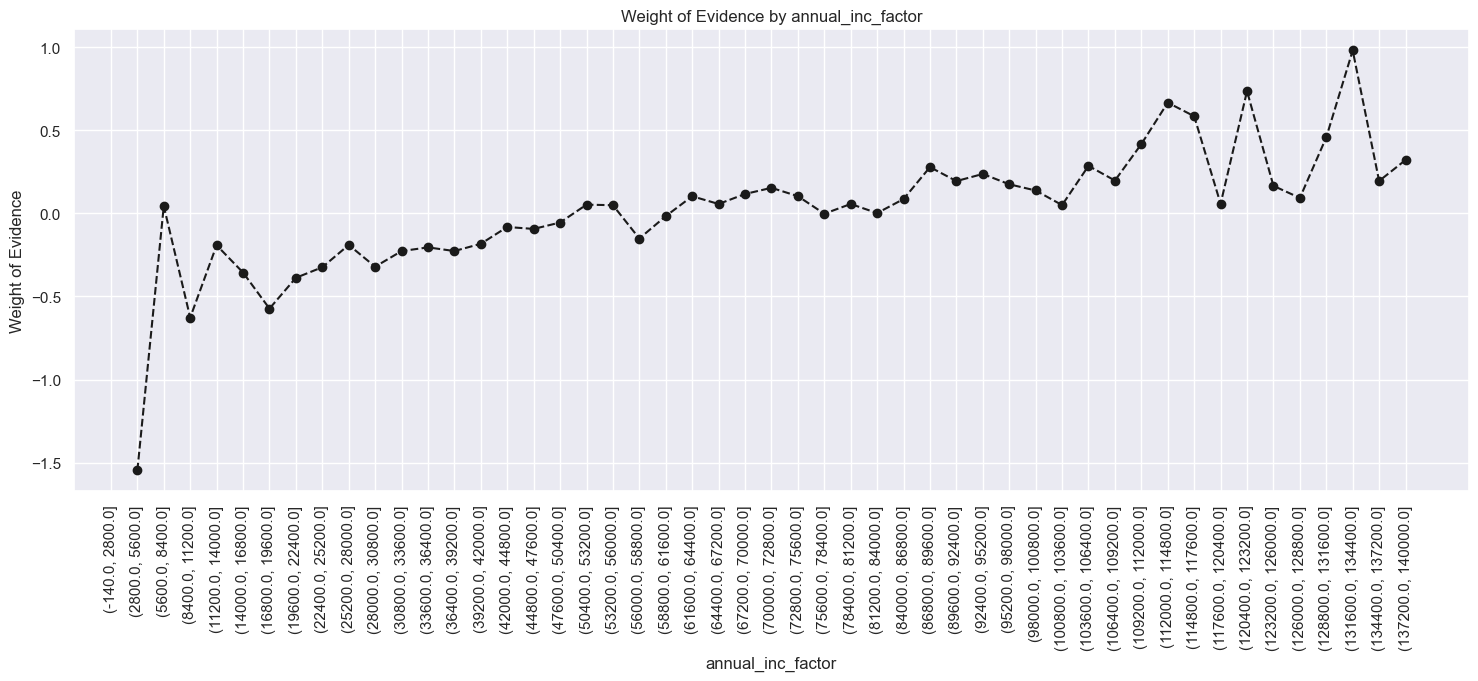

In [281]:
plot_by_woe(loan_data_temp, 90)

In [282]:
df_inputs_prepr['annual_inc:<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
df_inputs_prepr['annual_inc:20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
df_inputs_prepr['annual_inc:30K-40K'] = np.where((df_inputs_prepr['annual_inc'] > 30000) & (df_inputs_prepr['annual_inc'] <= 40000), 1, 0)
df_inputs_prepr['annual_inc:40K-50K'] = np.where((df_inputs_prepr['annual_inc'] > 40000) & (df_inputs_prepr['annual_inc'] <= 50000), 1, 0)
df_inputs_prepr['annual_inc:50K-60K'] = np.where((df_inputs_prepr['annual_inc'] > 50000) & (df_inputs_prepr['annual_inc'] <= 60000), 1, 0)
df_inputs_prepr['annual_inc:60K-70K'] = np.where((df_inputs_prepr['annual_inc'] > 60000) & (df_inputs_prepr['annual_inc'] <= 70000), 1, 0)
df_inputs_prepr['annual_inc:70K-80K'] = np.where((df_inputs_prepr['annual_inc'] > 70000) & (df_inputs_prepr['annual_inc'] <= 80000), 1, 0)
df_inputs_prepr['annual_inc:80K-90K'] = np.where((df_inputs_prepr['annual_inc'] > 80000) & (df_inputs_prepr['annual_inc'] <= 90000), 1, 0)
df_inputs_prepr['annual_inc:90K-100K'] = np.where((df_inputs_prepr['annual_inc'] > 90000) & (df_inputs_prepr['annual_inc'] <= 100000), 1, 0)
df_inputs_prepr['annual_inc:100K-120K'] = np.where((df_inputs_prepr['annual_inc'] > 100000) & (df_inputs_prepr['annual_inc'] <= 120000), 1, 0)
df_inputs_prepr['annual_inc:120K-140K'] = np.where((df_inputs_prepr['annual_inc'] > 120000) & (df_inputs_prepr['annual_inc'] <= 140000), 1, 0)
df_inputs_prepr['annual_inc:>140K'] = np.where((df_inputs_prepr['annual_inc'] > 140000), 1, 0)

#### 6.2.16. mths_since_last_delinq

In [283]:
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
loan_data_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_targets_prepr[df_inputs_prepr_temp.index])
loan_data_temp

,mths_since_last_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.176, 3.52]",7261,0.973833,0.033440,7071.0,190.0,0.033183,0.047041,-0.349003,NaN,NaN,inf
1,"(3.52, 7.04]",15763,0.978367,0.072596,15422.0,341.0,0.072372,0.084427,-0.154068,0.039189,0.194935,inf
2,"(7.04, 10.56]",12365,0.980348,0.056947,12122.0,243.0,0.056886,0.060163,-0.056020,0.015486,0.098048,inf
3,"(10.56, 14.08]",16125,0.979721,0.074263,15798.0,327.0,0.074136,0.080961,-0.088058,0.017251,0.032037,inf
4,"(14.08, 17.6]",11384,0.976985,0.052429,11122.0,262.0,0.052193,0.064868,-0.217400,0.021943,0.129343,inf
5,"(17.6, 21.12]",14291,0.983626,0.065817,14057.0,234.0,0.065966,0.057935,0.129818,0.013773,0.347219,inf
6,"(21.12, 24.64]",10544,0.982170,0.048560,10356.0,188.0,0.048598,0.046546,0.043143,0.017368,0.086675,inf
7,"(24.64, 28.16]",13761,0.981760,0.063376,13510.0,251.0,0.063399,0.062144,0.019996,0.014801,0.023147,inf
8,"(28.16, 31.68]",9867,0.985001,0.045442,9719.0,148.0,0.045609,0.036643,0.218889,0.017790,0.198893,inf
9,"(31.68, 35.2]",12583,0.985218,0.057951,12397.0,186.0,0.058176,0.046051,0.233727,0.012567,0.014837,inf


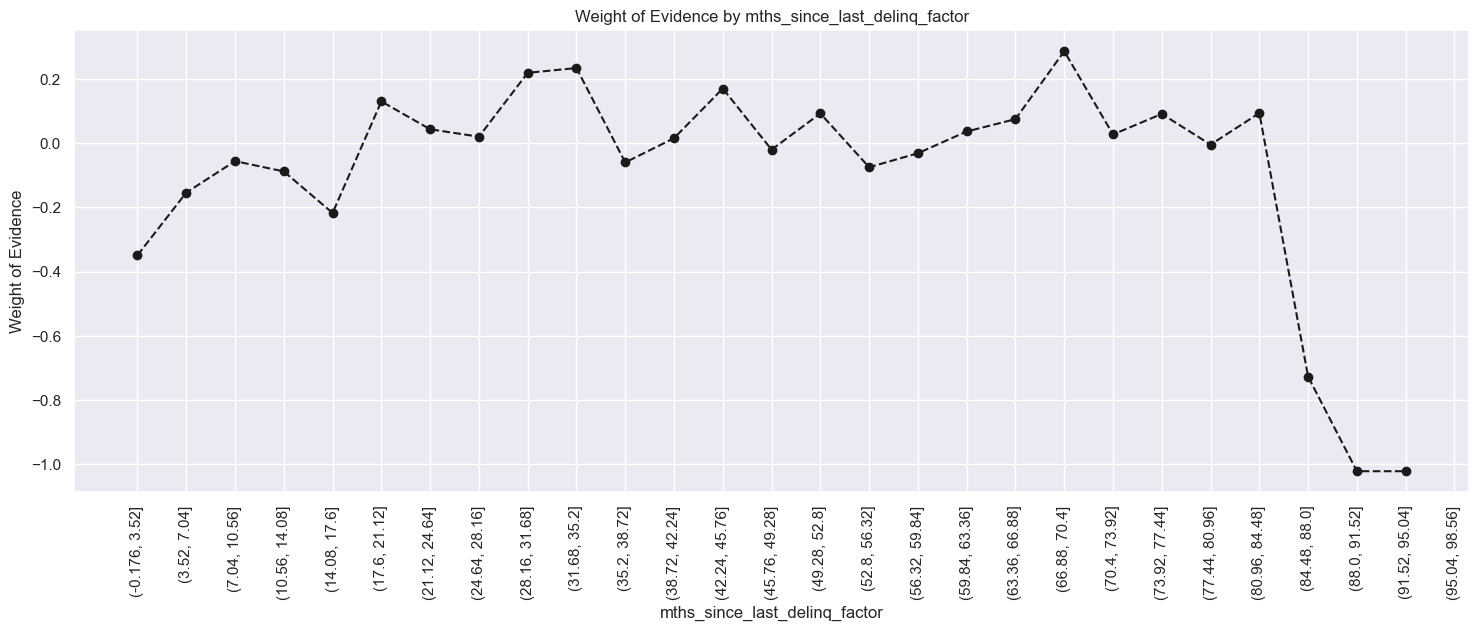

In [284]:
plot_by_woe(loan_data_temp, 90)

In [285]:
df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq:0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] <= 3), 1, 0)
df_inputs_prepr['mths_since_last_delinq:4-30'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 4) & (df_inputs_prepr['mths_since_last_delinq'] <= 30), 1, 0)
df_inputs_prepr['mths_since_last_delinq:31-56'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 31) & (df_inputs_prepr['mths_since_last_delinq'] <= 56), 1, 0)
df_inputs_prepr['mths_since_last_delinq:>=57'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 57), 1, 0)

#### 6.2.17. dti

In [286]:
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 50)

In [287]:
loan_data_temp = woe_ordered_continuous(df_inputs_prepr, 'dti_factor', df_targets_prepr)
loan_data_temp

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9.999, 199.98]",421089,0.981355,0.999988,413238.0,7851.0,0.999988,1.0,-0.000012,NaN,NaN,inf
1,"(199.98, 399.96]",1,1.000000,0.000002,1.0,0.0,0.000002,0.0,inf,0.999985,inf,inf
2,"(399.96, 599.94]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(599.94, 799.92]",1,1.000000,0.000002,1.0,0.0,0.000002,0.0,inf,NaN,NaN,inf
4,"(799.92, 999.9]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
5,"(999.9, 1199.88]",1,1.000000,0.000002,1.0,0.0,0.000002,0.0,inf,NaN,NaN,inf
6,"(1199.88, 1399.86]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
7,"(1399.86, 1599.84]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(1599.84, 1799.82]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(1799.82, 1999.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


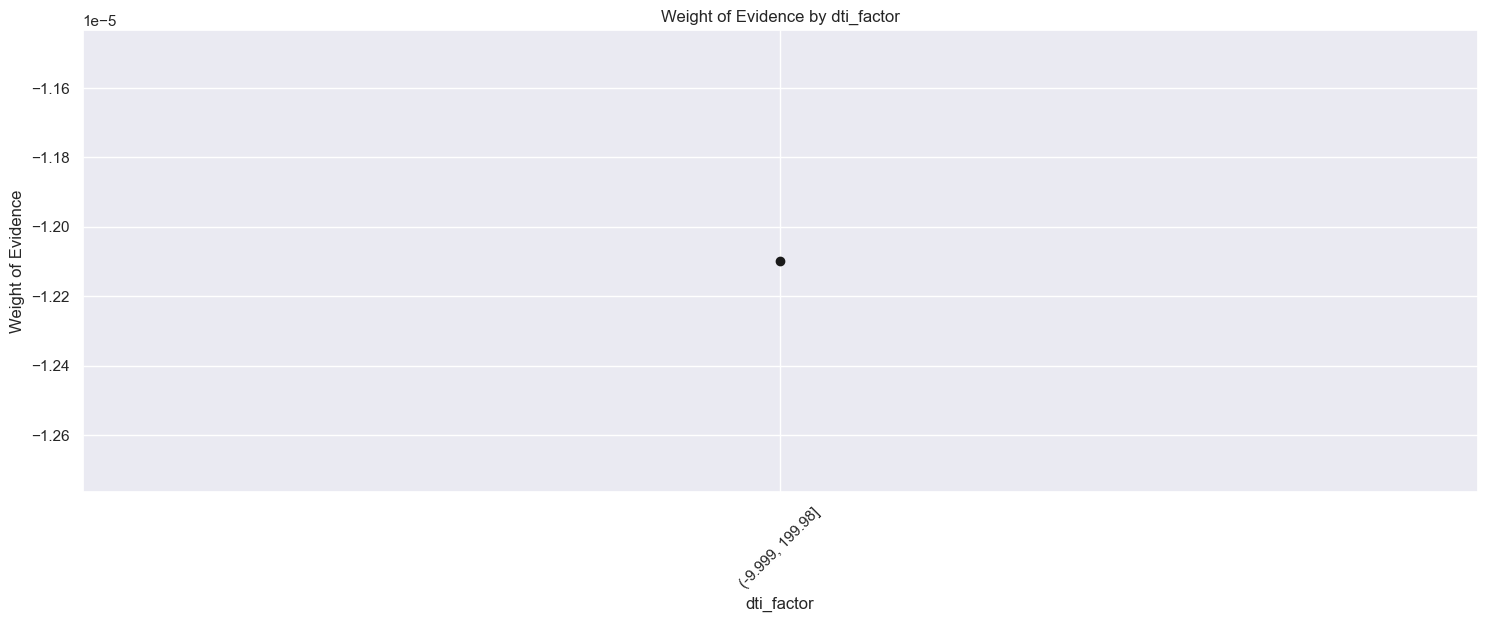

In [288]:
plot_by_woe(loan_data_temp,45)

In [289]:
df_inputs_prepr['dti:<1.6'] = np.where((df_inputs_prepr['dti'] <= 1.6), 1, 0)
df_inputs_prepr['dti:1.6-3.199'] = np.where((df_inputs_prepr['dti'] > 1.6) & (df_inputs_prepr['dti'] <= 3.199), 1, 0)
df_inputs_prepr['dti:3.199-7.198'] = np.where((df_inputs_prepr['dti'] > 3.199) & (df_inputs_prepr['dti'] <= 7.198), 1, 0)
df_inputs_prepr['dti:7.198-11.19'] = np.where((df_inputs_prepr['dti'] > 7.198) & (df_inputs_prepr['dti'] <= 11.197), 1, 0)
df_inputs_prepr['dti:11.197-15.196'] = np.where((df_inputs_prepr['dti'] > 11.197) & (df_inputs_prepr['dti'] <= 15.196), 1, 0)
df_inputs_prepr['dti:15.196-15.996'] = np.where((df_inputs_prepr['dti'] > 15.196) & (df_inputs_prepr['dti'] <= 15.996), 1, 0)
df_inputs_prepr['dti:15.996-19.995'] = np.where((df_inputs_prepr['dti'] > 15.996) & (df_inputs_prepr['dti'] <= 19.995), 1, 0)
df_inputs_prepr['dti:19.995-23.194'] = np.where((df_inputs_prepr['dti'] > 19.995) & (df_inputs_prepr['dti'] <= 23.194), 1, 0)
df_inputs_prepr['dti:23.194-23.994'] = np.where((df_inputs_prepr['dti'] > 23.194) & (df_inputs_prepr['dti'] <= 23.994), 1, 0)
df_inputs_prepr['dti:23.994-25.594'] = np.where((df_inputs_prepr['dti'] > 23.994) & (df_inputs_prepr['dti'] <= 25.594), 1, 0)
df_inputs_prepr['dti:25.594-30.392'] = np.where((df_inputs_prepr['dti'] > 25.594) & (df_inputs_prepr['dti'] <= 30.392), 1, 0)
df_inputs_prepr['dti:>30.392'] = np.where((df_inputs_prepr['dti'] > 30.392), 1, 0)

#### 6.2.18. mths_since_last_record

In [290]:
df_inputs_prepr['mths_since_last_record'].unique()

array([ nan,  67.,  30.,   2.,  12.,  66.,  61.,  89.,  71.,  81.,  75.,
        39.,  86., 106.,  50.,  76.,  57.,  74.,  48.,  91.,  22.,  16.,
        58.,  35.,  47.,  69.,  84.,  46., 113.,  54.,  62.,  68.,  55.,
        56.,  42.,   9.,  53.,  64.,  41.,  27.,  73.,  63.,  83.,  70.,
        28.,  37.,  82., 109.,  95.,  65.,  17.,  23.,  77., 111., 117.,
        11.,  79.,  38., 112.,  78.,  26.,   1.,  92.,  36.,  90.,  80.,
        60.,  51.,  85.,  40.,  24.,  87.,  98.,   8., 115.,  45.,  25.,
        44.,  52., 114.,  13.,  88.,  49., 107., 104., 101.,  97.,  33.,
        94.,  93.,  29., 103.,  72.,  59.,  34., 100.,  14.,  15.,  19.,
       105.,  18.,  31.,  21.,  10., 108.,   5., 116., 102.,  99.,  96.,
        43.,   3.,  32.,  20., 119., 118.,   4., 110.,   7.,   0.,   6.,
       120.])

In [291]:
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_record'])]
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
loan_data_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_record_factor', df_targets_prepr[df_inputs_prepr_temp.index])
loan_data_temp

,mths_since_last_record_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.12, 2.4]",87,0.965517,0.001169,84.0,3.0,0.001152,0.002041,-0.572239,NaN,NaN,0.060687
1,"(2.4, 4.8]",161,0.968944,0.002164,156.0,5.0,0.002139,0.003401,-0.464025,0.000987,0.108214,0.060687
2,"(4.8, 7.2]",344,0.976744,0.004623,336.0,8.0,0.004606,0.005442,-0.166774,0.002468,0.297252,0.060687
3,"(7.2, 9.6]",291,0.982818,0.003911,286.0,5.0,0.003921,0.003401,0.142111,0.000685,0.308884,0.060687
4,"(9.6, 12.0]",537,0.970205,0.007216,521.0,16.0,0.007142,0.010884,-0.421282,0.003222,0.563393,0.060687
5,"(12.0, 14.4]",404,0.985149,0.005429,398.0,6.0,0.005456,0.004082,0.290249,0.001686,0.711531,0.060687
6,"(14.4, 16.8]",410,0.980488,0.005510,402.0,8.0,0.005511,0.005442,0.012567,0.000055,0.277682,0.060687
7,"(16.8, 19.2]",693,0.987013,0.009313,684.0,9.0,0.009377,0.006122,0.426290,0.003866,0.413723,0.060687
8,"(19.2, 21.6]",521,0.986564,0.007001,514.0,7.0,0.007046,0.004762,0.391870,0.002331,0.034420,0.060687
9,"(21.6, 24.0]",825,0.979394,0.011086,808.0,17.0,0.011077,0.011565,-0.043095,0.004030,0.434964,0.060687


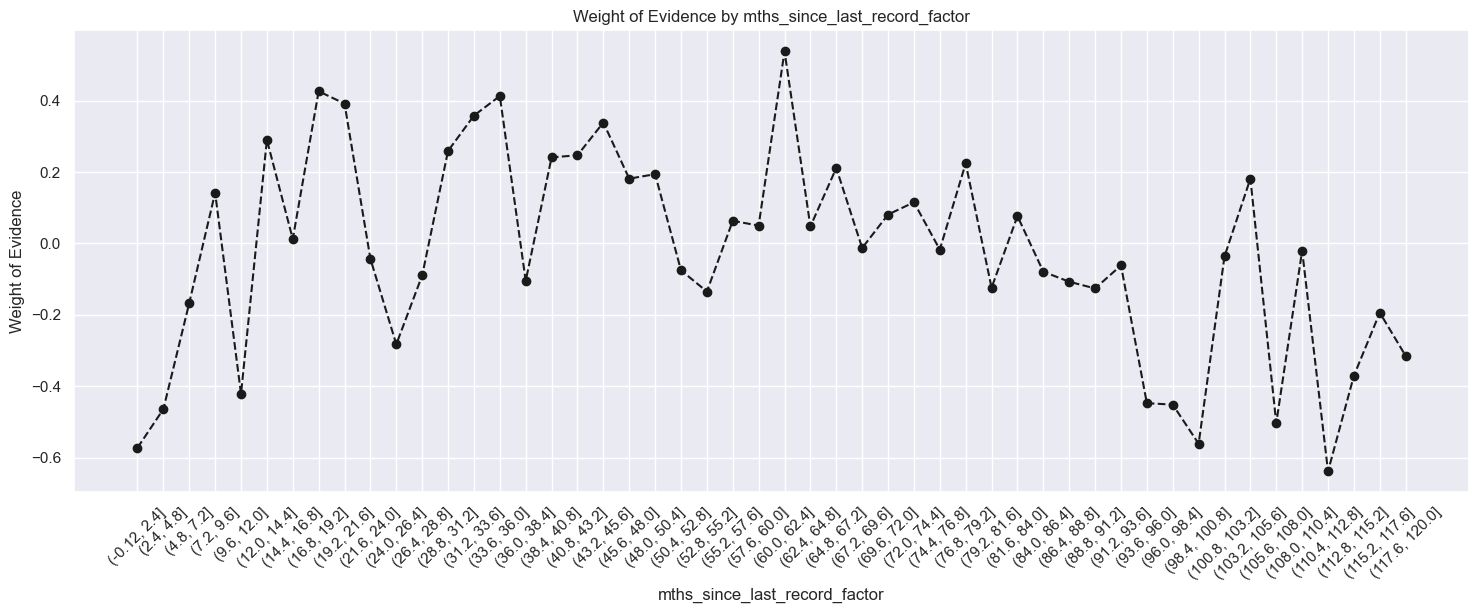

In [292]:
plot_by_woe(loan_data_temp,45)

In [293]:
df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_record:<=2.42'] = np.where((df_inputs_prepr['mths_since_last_record'] <= 2.42), 1, 0)
df_inputs_prepr['mths_since_last_record:2.42-38.72'] = np.where((df_inputs_prepr['mths_since_last_record'] > 2.42) & (df_inputs_prepr['mths_since_last_record'] <= 38.72), 1, 0)
df_inputs_prepr['mths_since_last_record:38.72-48.4'] = np.where((df_inputs_prepr['mths_since_last_record'] > 38.72) & (df_inputs_prepr['mths_since_last_record'] <= 48.4), 1, 0)
df_inputs_prepr['mths_since_last_record:48.4-62.92'] = np.where((df_inputs_prepr['mths_since_last_record'] > 48.4) & (df_inputs_prepr['mths_since_last_record'] <= 62.92), 1, 0)
df_inputs_prepr['mths_since_last_record:62.92-65.34'] = np.where((df_inputs_prepr['mths_since_last_record'] > 62.92) & (df_inputs_prepr['mths_since_last_record'] <= 65.34), 1, 0)
df_inputs_prepr['mths_since_last_record:65.34-77.44'] = np.where((df_inputs_prepr['mths_since_last_record'] > 65.34) & (df_inputs_prepr['mths_since_last_record'] <= 77.44), 1, 0)
df_inputs_prepr['mths_since_last_record:77.44-82.28'] = np.where((df_inputs_prepr['mths_since_last_record'] > 77.44) & (df_inputs_prepr['mths_since_last_record'] <= 82.28), 1, 0)
df_inputs_prepr['mths_since_last_record:82.28-94.38'] = np.where((df_inputs_prepr['mths_since_last_record'] > 82.28) & (df_inputs_prepr['mths_since_last_record'] <= 94.38), 1, 0)
df_inputs_prepr['mths_since_last_record:94.38-106.48'] = np.where((df_inputs_prepr['mths_since_last_record'] > 94.38) & (df_inputs_prepr['mths_since_last_record'] <= 106.48), 1, 0)
df_inputs_prepr['mths_since_last_record:>106.48'] = np.where((df_inputs_prepr['mths_since_last_record'] > 106.48), 1, 0)

# IV. Exporting 2015 dataset 

In [294]:
loan_data_inputs_2015 = df_inputs_prepr
loan_data_targets_2015 = df_targets_prepr

In [295]:
loan_data_inputs_2015.to_csv('loan_data_inputs_2015.csv')
loan_data_targets_2015.to_csv('loan_data_targets_2015.csv')

In [296]:
inputs_train_with_ref_cat = pd.read_csv('inputs_train_with_ref_cat.csv', index_col = 0)
inputs_2015_with_ref_cat = loan_data_inputs_2015.loc[: ,feature_list]

# V. Calculating credit scores for 2015 data

we need to score both the train data used to build the PD model and the new data

In [297]:
df_scorecard = pd.read_csv('df_scorecard.csv', index_col = 0)

In [298]:
scorecard_scores = df_scorecard['Score']
scorecard_scores = scorecard_scores.values.reshape(98, 1)

## 1. 2007 - 2014 dataset

In [299]:
inputs_train_with_ref_cat_w_intercept = inputs_train_with_ref_cat
inputs_train_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)
inputs_train_with_ref_cat_w_intercept = inputs_train_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]
inputs_train_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:oth__h__med__r_en,purpose:va__wed__debt_cons,purpose:home_impr__maj_pur__car__cre_c,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,total_acc:15- 30,total_acc:30-60,total_acc:>60,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<1.6,dti:1.6-3.199,dti:3.199-7.198,dti:7.198-11.19,dti:11.197-15.196,dti:15.196-15.996,dti:15.996-19.995,dti:19.995-23.194,dti:23.194-23.994,dti:23.994-25.594,dti:25.594-30.392,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:2.42-38.72,mths_since_last_record:38.72-48.4,mths_since_last_record:48.4-62.92,mths_since_last_record:62.92-65.34,mths_since_last_record:65.34-77.44,mths_since_last_record:77.44-82.28,mths_since_last_record:82.28-94.38,mths_since_last_record:94.38-106.48,mths_since_last_record:>106.48,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA,verification_status:Verified,purpose:educ__sm_b_mov,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,total_acc:<15.0,annual_inc:<20K,dti:>30.392,mths_since_last_delinq:0-3,mths_since_last_record:<=2.42
427211,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
206088,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
136020,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
412305,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
36159,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0


In [300]:
y_scores_train = inputs_train_with_ref_cat_w_intercept.dot(scorecard_scores)
y_scores_train.head()

,0
427211,673.0
206088,561.0
136020,663.0
412305,515.0
36159,481.0


In [301]:
inputs_train_with_ref_cat_w_intercept = pd.concat([inputs_train_with_ref_cat_w_intercept, y_scores_train], axis = 1)
inputs_train_with_ref_cat_w_intercept.columns.values[inputs_train_with_ref_cat_w_intercept.shape[1] - 1] = 'Score'

Since PSI compares the distribution between two datasets, we need the distribution expressed as percentages within each group. Because the score is a continuous variable, it’s difficult to compare directly, so we:
- Divide the scores into bins, e.g., 300–350, 350–400, ..., 800–850.
- Create dummy variables for each bin so that each customer falls into exactly one bin.

In [302]:
inputs_train_with_ref_cat_w_intercept['Score:300-350'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 300) & (inputs_train_with_ref_cat_w_intercept['Score'] < 350), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:350-400'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 350) & (inputs_train_with_ref_cat_w_intercept['Score'] < 400), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:400-450'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 400) & (inputs_train_with_ref_cat_w_intercept['Score'] < 450), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:450-500'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 450) & (inputs_train_with_ref_cat_w_intercept['Score'] < 500), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:500-550'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 500) & (inputs_train_with_ref_cat_w_intercept['Score'] < 550), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:550-600'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 550) & (inputs_train_with_ref_cat_w_intercept['Score'] < 600), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:600-650'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 600) & (inputs_train_with_ref_cat_w_intercept['Score'] < 650), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:650-700'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 650) & (inputs_train_with_ref_cat_w_intercept['Score'] < 700), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:700-750'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 700) & (inputs_train_with_ref_cat_w_intercept['Score'] < 750), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:750-800'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 750) & (inputs_train_with_ref_cat_w_intercept['Score'] < 800), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:800-850'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 800) & (inputs_train_with_ref_cat_w_intercept['Score'] <= 850), 1, 0)

## 2. 2015 dataset

Do the same for 2015 dataset.

In [303]:
inputs_2015_with_ref_cat_w_intercept = inputs_2015_with_ref_cat
inputs_2015_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)
inputs_2015_with_ref_cat_w_intercept = inputs_2015_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]
inputs_2015_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:oth__h__med__r_en,purpose:va__wed__debt_cons,purpose:home_impr__maj_pur__car__cre_c,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,total_acc:15- 30,total_acc:30-60,total_acc:>60,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<1.6,dti:1.6-3.199,dti:3.199-7.198,dti:7.198-11.19,dti:11.197-15.196,dti:15.196-15.996,dti:15.996-19.995,dti:19.995-23.194,dti:23.194-23.994,dti:23.994-25.594,dti:25.594-30.392,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:2.42-38.72,mths_since_last_record:38.72-48.4,mths_since_last_record:48.4-62.92,mths_since_last_record:62.92-65.34,mths_since_last_record:65.34-77.44,mths_since_last_record:77.44-82.28,mths_since_last_record:82.28-94.38,mths_since_last_record:94.38-106.48,mths_since_last_record:>106.48,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA,verification_status:Verified,purpose:educ__sm_b_mov,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,total_acc:<15.0,annual_inc:<20K,dti:>30.392,mths_since_last_delinq:0-3,mths_since_last_record:<=2.42
0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [304]:
y_scores_2015 = inputs_2015_with_ref_cat_w_intercept.dot(scorecard_scores)
y_scores_2015.head()

,0
0,728.0
1,745.0
2,618.0
3,617.0
4,700.0


In [305]:
inputs_2015_with_ref_cat_w_intercept = pd.concat([inputs_2015_with_ref_cat_w_intercept, y_scores_2015], axis = 1)
inputs_2015_with_ref_cat_w_intercept.columns.values[inputs_2015_with_ref_cat_w_intercept.shape[1] - 1] = 'Score'

In [306]:
inputs_2015_with_ref_cat_w_intercept['Score:300-350'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 300) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 350), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:350-400'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 350) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 400), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:400-450'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 400) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 450), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:450-500'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 450) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 500), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:500-550'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 500) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 550), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:550-600'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 550) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 600), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:600-650'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 600) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 650), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:650-700'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 650) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 700), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:700-750'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 700) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 750), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:750-800'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 750) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 800), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:800-850'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 800) & (inputs_2015_with_ref_cat_w_intercept['Score'] <= 850), 1, 0)

In [307]:
inputs_2015_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:oth__h__med__r_en,purpose:va__wed__debt_cons,purpose:home_impr__maj_pur__car__cre_c,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,total_acc:15- 30,total_acc:30-60,total_acc:>60,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<1.6,dti:1.6-3.199,dti:3.199-7.198,dti:7.198-11.19,dti:11.197-15.196,dti:15.196-15.996,dti:15.996-19.995,dti:19.995-23.194,dti:23.194-23.994,dti:23.994-25.594,dti:25.594-30.392,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:2.42-38.72,mths_since_last_record:38.72-48.4,mths_since_last_record:48.4-62.92,mths_since_last_record:62.92-65.34,mths_since_last_record:65.34-77.44,mths_since_last_record:77.44-82.28,mths_since_last_record:82.28-94.38,mths_since_last_record:94.38-106.48,mths_since_last_record:>106.48,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA,verification_status:Verified,purpose:educ__sm_b_mov,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,total_acc:<15.0,annual_inc:<20K,dti:>30.392,mths_since_last_delinq:0-3,mths_since_last_record:<=2.42,Score,Score:300-350,Score:350-400,Score:400-450,Score:450-500,Score:500-550,Score:550-600,Score:600-650,Score:650-700,Score:700-750,Score:750-800,Score:800-850
0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,728.0,0,0,0,0,0,0,0,0,1,0,0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,745.0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,618.0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,617.0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,700.0,0,0,0,0,0,0,0,0,1,0,0


# VI. Population Stability Index: Calculation and Interpretation

Calculate proportions

In [308]:
PSI_calc_train = inputs_train_with_ref_cat_w_intercept.sum() / inputs_train_with_ref_cat_w_intercept.shape[0]
PSI_calc_train

Intercept        1.000000
grade:A          0.160200
grade:B          0.294160
grade:C          0.268733
grade:D          0.164862
                   ...   
Score:600-650    0.180405
Score:650-700    0.100802
Score:700-750    0.036909
Score:750-800    0.002590
Score:800-850    0.000000
Length: 110, dtype: float64

In [309]:
PSI_calc_2015 = inputs_2015_with_ref_cat_w_intercept.sum() / inputs_2015_with_ref_cat_w_intercept.shape[0]
PSI_calc_2015

Intercept        1.000000
grade:A          0.174154
grade:B          0.279287
grade:C          0.286318
grade:D          0.148789
                   ...   
Score:600-650    0.267698
Score:650-700    0.217809
Score:700-750    0.177412
Score:750-800    0.031195
Score:800-850    0.000076
Length: 110, dtype: float64

Compute PSI contributions

In [310]:
PSI_calc = pd.concat([PSI_calc_train, PSI_calc_2015], axis = 1)
PSI_calc = PSI_calc.reset_index()
PSI_calc['Original feature name'] = PSI_calc['index'].str.split(':').str[0]
PSI_calc.columns = ['index', 'Proportions_Train', 'Proportions_New', 'Original feature name']
PSI_calc = PSI_calc[np.array(['index', 'Original feature name', 'Proportions_Train', 'Proportions_New'])]
PSI_calc = PSI_calc[(PSI_calc['index'] != 'Intercept') & (PSI_calc['index'] != 'Score')]
PSI_calc['Contribution'] = np.where((PSI_calc['Proportions_Train'] == 0) | (PSI_calc['Proportions_New'] == 0), 0,
                                    (PSI_calc['Proportions_New'] - PSI_calc['Proportions_Train']) * np.log(PSI_calc['Proportions_New'] / PSI_calc['Proportions_Train']))
PSI_calc

,index,Original feature name,Proportions_Train,Proportions_New,Contribution
1,grade:A,grade,0.160200,0.174154,0.001165
2,grade:B,grade,0.294160,0.279287,0.000772
3,grade:C,grade,0.268733,0.286318,0.001115
4,grade:D,grade,0.164862,0.148789,0.001649
5,grade:E,grade,0.076702,0.082993,0.000496
...,...,...,...,...,...
105,Score:600-650,Score,0.180405,0.267698,0.034451
106,Score:650-700,Score,0.100802,0.217809,0.090149
107,Score:700-750,Score,0.036909,0.177412,0.220593
108,Score:750-800,Score,0.002590,0.031195,0.071191


In [311]:
PSI_calc.groupby('Original feature name')['Contribution'].sum()

Original feature name
Score                     1.193271
addr_state                0.016891
annual_inc                0.005445
dti                       0.067128
emp_length                0.007452
grade                     0.006775
home_ownership            0.004275
initial_list_status       0.333717
int_rate                  0.079230
mths_since_issue_d        2.388305
mths_since_last_delinq    0.011594
mths_since_last_record    0.061663
purpose                   0.005636
term                      0.013099
total_acc                 0.147215
verification_status       0.048219
Name: Contribution, dtype: float64

The variables Score, mths_since_issue_d, and initial_list_status show high PSI values, indicating that their distributions have significantly shifted between the training data and the 2015 dataset. This suggests potential population changes or data drift, meaning the model’s predictions might become less reliable for these features.